# Airbnb Cape Town Business Analysis.

---

## Overview

This project analyzes Airbnb listings and reviews in Cape Town to uncover key drivers of revenue, guest satisfaction, and booking behavior. Using a blend of structured data modeling and NLP techniques, we built a price prediction model, extracted review topics using BERTopic, and performed sentiment analysis to surface actionable insights for hosts and Airbnb itself.

---

## Introduction

This project focuses on analyzing Airbnb listings in Cape Town with an emphasis on predictive modeling to understand and forecast listing performance. Using data from Inside Airbnb, the project combines comprehensive data cleaning, feature engineering, and exploratory analysis to build models that predict nightly prices, occupancy rates, and potential revenue. In addition, geospatial features and listing attributes are incorporated to identify high-performing neighborhoods and listings. Sentiment and topic analysis of guest reviews further enhance the predictive insights by capturing factors that influence customer satisfaction. The goal is to equip hosts, investors, and property managers with data-driven predictions and actionable recommendations to optimize pricing strategies, improve occupancy, and maximize revenue in the short-term rental market.


---

## Business Understanding

The short-term rental market, exemplified by platforms like Airbnb, is highly dynamic and competitive. Hosts, property managers, and investors face challenges in setting optimal pricing, maintaining high occupancy rates, and maximizing revenue while meeting guest expectations. Understanding the factors that drive listing performance is critical for making informed business decisions.

This project aims to address these challenges by providing data-driven insights and predictive guidance. Specifically, it seeks to:

1. Forecast pricing and revenue: Help hosts and investors set competitive nightly rates and estimate potential earnings.

2. Predict occupancy: Identify the factors that influence booking frequency to improve property utilization.

3. Evaluate location potential: Use geospatial analysis to highlight neighborhoods and listings with higher performance potential.

4. Understand customer preferences: Analyze guest reviews to extract trends in satisfaction, informing service improvements and strategic positioning.

By combining predictive modeling with location and review analysis, the project empowers stakeholders to optimize pricing strategies, enhance occupancy, and make smarter investment decisions in Cape Town’s Airbnb market.

---

## Business Problem

Airbnb hosts in Cape Town face increasing competition and lack tools to optimize their listings effectively. They often rely on intuition rather than data to determine pricing, interpret reviews, and improve guest satisfaction. 

To address this, we asked:

- What factors most strongly predict listing price, listing revenue and occupancy?
- What are guests saying in reviews, and what themes consistently appear?
- How do these themes correlate with positive or negative sentiment?
- Can this insight help hosts improve their listings and Airbnb refine its search ranking?

Understanding these questions helps Airbnb and hosts alike boost guest satisfaction and optimize revenue potential.

---

## Data Understanding

We used multiple datasets from Inside Airbnb, including:

- **listings.csv**: Structured data for all listings.
- **listings_detailed.csv**: Extended version with engineered features like `estimated_revenue_l365d` and `estimated_occupancy_l365d`.
- **reviews_detailed.csv**: Over 600,000 detailed guest reviews.
- **neighbourhoods.csv**
- **neighbourhoods.geojson**


**Target Variables:**
- For prediction: `price`, `estimated_occupancy_l365d`
- For NLP: guest `comments` from reviews

Key features included listing characteristics (e.g., `property_type`, `accommodates`, `beds`), textual feedback, and derived metrics like revenue.

---

## 1. Data Preparation and Cleaning

In this start, the raw Airbnb dataset was cleaned and prepared for analysis and modeling. This involved handling missing values, correcting data types, addressing outliers, and standardizing numeric and categorical features. Additional features, such as the number of amenities, host experience, and combined latitude-longitude coordinates, were created to enhance predictive modeling and geospatial analysis.



In [165]:
# ====== Data Handling ======
import pandas as pd
import numpy as np
import ast
from collections import Counter

# ====== Visualization ======
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# ====== Preprocessing ======
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PowerTransformer, QuantileTransformer

# ====== Regression & Tree Models ======
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from scipy.stats import randint, uniform

# ====== Clustering ======
from sklearn.cluster import KMeans

# ====== Correlation & Statistics ======
from scipy.stats import pearsonr, spearmanr

# ====== NLP ======
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from bertopic import BERTopic

# ====== Geospatial ======
import geopandas as gpd
import folium
from folium.features import GeoJsonTooltip
from shapely.geometry import Point
from branca.element import Template, MacroElement, Element


# ====== Utilities ======
import warnings
warnings.filterwarnings("ignore")
import joblib
from joblib import dump
import pickle


from scipy.stats import randint, uniform

### 1.2: Loading Data.

In [78]:
# Load datasets
listings = pd.read_csv("Data/listings.csv")
calendar = pd.read_csv("Data/calendar.csv.gz")
reviews = pd.read_csv("Data/reviews2.csv")
neighbourhoods = pd.read_csv("Data/neighbourhoods.csv")
listings_detailed = pd.read_csv("Data/listings.csv.gz", compression='gzip')
reviews_detailed = pd.read_csv("Data/reviews1.csv.gz", compression='gzip')

### Feature Engineering from Calendar and Reviews Data

To better understand listing performance and enhance the predictive power of our dataset, we extracted new features from the **calendar** and **reviews** datasets. These features were aggregated at the listing level and later merged with the main listings dataset.

####  Standardizing Column Names
calendar.rename(columns={'listing_id': 'id'}, inplace=True)

reviews.rename(columns={'listing_id': 'id'}, inplace=True)

We standardized column names by renaming listing_id to id in both calendar and reviews. This ensures consistency across datasets and enables seamless merging with the main listings dataset.

Prices in the calendar dataset were originally stored as strings with dollar signs and commas. We cleaned and converted them into numeric format to enable mathematical operations like computing averages.

In [79]:
# Rename keys for consistent merging
calendar.rename(columns={'listing_id': 'id'}, inplace=True)
reviews.rename(columns={'listing_id': 'id'}, inplace=True)

# Convert calendar price to numeric
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)

# Aggregate calendar data to listing level
calendar_agg = calendar.groupby('id').agg({
    'price': 'mean',
    'available': lambda x: (x == 't').mean()
}).rename(columns={
    'price': 'avg_price',
    'available': 'availability_rate'
}).reset_index()

# Aggregate reviews data to listing level
reviews_agg = reviews.groupby('id').agg({
    'date': ['count', 'max']
})
reviews_agg.columns = ['review_count', 'latest_review']
reviews_agg.reset_index(inplace=True)


This aggregation step (final step) produces two new features per listing:

 - avg_price: Average nightly price.

 - availability_rate: Proportion of days that a listing was marked available.

These metrics help quantify a listing’s pricing strategy and availability behavior

and finally:

 - review_count: Total number of reviews for each listing — a proxy for popularity and demand.

 - latest_review: The most recent review date — useful for identifying active or inactive listings.



#### Why This Matters
These engineered features were critical in:

 - Enhancing our price and revenue prediction models.

 - Segmenting listings based on availability patterns and guest engagement.

 - Enriching our dataset with time-based and behavioral context, beyond static listing information.

By summarizing granular calendar and review data into meaningful listing-level indicators, we created a more robust foundation for both predictive modeling and descriptive insights.

In [80]:
neighbourhoods.head()

,neighbourhood_group,neighbourhood
0,NaN,Ward 1
1,NaN,Ward 10
2,NaN,Ward 100
3,NaN,Ward 101
4,NaN,Ward 102


### Merging Datasets into a Unified DataFrame

To build a rich dataset that captures multiple dimensions of Airbnb listings in Cape Town, we consolidated data from several sources. This merging process ensured that each listing record is enhanced with relevant pricing, review, and location-based information.

We started with the main listings dataset, which contains core information for each property (e.g., location, host, room type). This serves as the base table for merging additional features.

In [157]:
# Start with listings as base
merged_df = listings.copy()

# Merge calendar averages
merged_df = merged_df.merge(calendar_agg, on='id', how='left')

# Merge review aggregates
merged_df = merged_df.merge(reviews_agg, on='id', how='left')

# Merge neighbourhood info
merged_df = merged_df.merge(neighbourhoods, on='neighbourhood', how='left')


### Feature Engineering and Data Consolidation

This section focuses on enhancing the dataset with meaningful features and consolidating relevant listing information. 

First, multiple review score columns—covering aspects such as overall rating, accuracy, cleanliness, check-in experience, communication, location, and value—are aggregated into a single `avg_rating` feature. This provides a simplified yet comprehensive measure of a listing’s overall guest satisfaction.  

Next, a subset of important features is selected from `listings_detailed`, including:  

- **Property characteristics:** `property_type`, `accommodates`, `bedrooms`, `beds`, `bathrooms`, `room_type`  
- **Host attributes:** `host_is_superhost`, `host_response_time`, `host_response_rate`  
- **Performance metrics:** `estimated_occupancy_l365d`, `reviews_per_month`  
- **Aggregated review score:** `avg_rating`  

This curated subset is then merged with the main dataset `merged_df` using the listing `id` as the key. The resulting dataset combines listing details, host information, and performance metrics, providing a solid foundation for exploratory analysis, predictive modeling, and feature-driven insights.


In [158]:

# Feature Engineering
# average of the ratings columns to 1 column 'avg_rating'

# columns to average
rating_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                  'review_scores_checkin', 'review_scores_communication',
                  'review_scores_location', 'review_scores_value']

# Create new column 'avg_rating' which is the row-wise mean of the selected columns
listings_detailed['avg_rating'] = listings_detailed[rating_columns].mean(axis=1)


# Select the relevant columns from listings_detailed
listings_detailed_subset = listings_detailed[[
    'id',
    'property_type',
    'accommodates',
    'bedrooms',
    'beds',
    'estimated_occupancy_l365d','bathrooms',
    'avg_rating','room_type','neighbourhood_cleansed','host_is_superhost','host_response_time','host_response_rate', 'reviews_per_month'
]]

# Merge with merged_df
merged_df = merged_df.merge(listings_detailed_subset, on='id', how='left')




In [159]:
merged_df.info()
merged_df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25882 entries, 0 to 25881
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              25882 non-null  int64  
 1   name                            25881 non-null  object 
 2   host_id                         25882 non-null  int64  
 3   host_name                       25880 non-null  object 
 4   neighbourhood_group_x           0 non-null      float64
 5   neighbourhood                   25882 non-null  object 
 6   latitude                        25882 non-null  float64
 7   longitude                       25882 non-null  float64
 8   room_type_x                     25882 non-null  object 
 9   price                           21016 non-null  float64
 10  minimum_nights                  25882 non-null  int64  
 11  number_of_reviews               25882 non-null  int64  
 12  last_review                     

,id,name,host_id,host_name,neighbourhood_group_x,neighbourhood,latitude,longitude,room_type_x,price,...,beds,estimated_occupancy_l365d,bathrooms,avg_rating,room_type_y,neighbourhood_cleansed,host_is_superhost,host_response_time,host_response_rate,reviews_per_month_y
count,2.588200e+04,25881,2.588200e+04,25880,0.0,25882,25882.000000,25882.000000,25882,21016.000000,...,21226.000000,25882.000000,21135.000000,20663.000000,25882,25882,24960,21106,21106,20663.000000
unique,NaN,25126,NaN,5463,NaN,86,NaN,NaN,4,NaN,...,NaN,NaN,NaN,NaN,4,86,2,4,58,NaN
top,NaN,Groovy Giraffe,NaN,Bianca,NaN,Ward 115,NaN,NaN,Entire home/apt,NaN,...,NaN,NaN,NaN,NaN,Entire home/apt,Ward 115,f,within an hour,100%,NaN
freq,NaN,96,NaN,404,NaN,5499,NaN,NaN,21303,NaN,...,NaN,NaN,NaN,NaN,21303,5499,17024,15164,16700,NaN
mean,6.193987e+17,NaN,2.107309e+08,NaN,NaN,NaN,-33.955507,18.472194,NaN,3267.091454,...,2.234712,40.346573,1.698368,4.777597,NaN,NaN,NaN,NaN,NaN,0.967318
std,5.473306e+17,NaN,2.068323e+08,NaN,NaN,NaN,0.098455,0.124231,NaN,7190.695528,...,1.795435,59.197990,1.225152,0.373077,NaN,NaN,NaN,NaN,NaN,1.074962
min,3.191000e+03,NaN,3.754000e+03,NaN,NaN,NaN,-34.262840,18.320200,NaN,160.000000,...,0.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.010000
25%,3.364584e+07,NaN,3.618844e+07,NaN,NaN,NaN,-34.014970,18.400300,NaN,981.000000,...,1.000000,0.000000,1.000000,4.741429,NaN,NaN,NaN,NaN,NaN,0.230000
50%,7.592885e+17,NaN,1.197750e+08,NaN,NaN,NaN,-33.927451,18.425365,NaN,1600.000000,...,2.000000,14.000000,1.000000,4.875714,NaN,NaN,NaN,NaN,NaN,0.630000
75%,1.143203e+18,NaN,3.811219e+08,NaN,NaN,NaN,-33.910028,18.482308,NaN,3000.000000,...,3.000000,54.000000,2.000000,4.952857,NaN,NaN,NaN,NaN,NaN,1.340000


### Dataset Summary

The Airbnb dataset contains **25,882 listings** in Cape Town and includes **35 columns** capturing listing attributes, host information, performance metrics, and review scores. The dataset combines both numeric and categorical features, providing a comprehensive view of each property.  

**Numeric features:**  
- `price`, `minimum_nights`, `bedrooms`, `beds`, `bathrooms` – describe the property size, capacity, and pricing.  
- `estimated_occupancy_l365d`, `reviews_per_month`, `avg_rating` – capture listing performance and guest satisfaction metrics.  
- Other numeric fields include `latitude` and `longitude` for location, and `availability_365` and `calculated_host_listings_count` for availability and host activity.  

**Categorical features:**  
- Property and room details: `property_type`, `room_type_x`, `room_type_y`  
- Location: `neighbourhood`, `neighbourhood_cleansed`  
- Host attributes: `host_is_superhost`, `host_response_time`, `host_response_rate`  

**Missing values:**  
- `price` has ~18.8% missing values.  
- `beds` (~18%), `bathrooms` (~18%), `avg_rating` (~20%), and `host_response_time` (~18%) contain missing entries.  
- Some columns like `neighbourhood_group_x` and `neighbourhood_group_y` are completely empty and will be dropped.  

**Unique values:**  
- There are **86 distinct neighborhoods**, **4 room types**, and **2 host superhost statuses**.  
- Host response times and rates have multiple categories reflecting responsiveness.  

**Observations:**  
- Some numeric fields (e.g., `price`, `minimum_nights`, `beds`) have extreme values and will require outlier handling.  
- The dataset contains duplicate columns (e.g., `room_type_x` and `room_type_y`) which will need consolidation.  
- Geospatial information (`latitude` and `longitude`) allows for mapping and neighborhood-level analysis.  

Overall, this dataset provides rich information on listing characteristics, host behavior, location, and performance metrics. Proper cleaning, feature engineering, and handling of missing values are essential to ensure reliable predictive modeling, clustering, and geospatial analysis.


### 1.2: Explatory Data Analysis

 #### Missing (Nan) Values


The next step was for **analyze missing values** in the `merged_df` DataFrame:

##### Purpose
To **identify and quantify missing data** across all columns, expressed as a **percentage of missing values**. This helps guide:
- Data cleaning
- Imputation strategies
- Column inclusion/exclusion for modeling



In [160]:
missing_percentage = merged_df.isnull().mean().sort_values(ascending=False) * 100
missing_percentage = missing_percentage[missing_percentage > 0]  # Filter only columns with missing values
print(missing_percentage)


neighbourhood_group_y    100.000000
neighbourhood_group_x    100.000000
license                   99.659995
last_review               20.164593
reviews_per_month_y       20.164593
latest_review             20.164593
review_count              20.164593
reviews_per_month_x       20.164593
avg_rating                20.164593
price                     18.800711
host_response_time        18.452979
host_response_rate        18.452979
bathrooms                 18.340932
beds                      17.989336
host_is_superhost          3.562321
bedrooms                   2.631172
avg_price                  0.100456
availability_rate          0.100456
host_name                  0.007727
name                       0.003864
dtype: float64


#### Data Cleaning & Imputation Strategy


In this step, the dataset is systematically cleaned to ensure high-quality, reliable data for analysis and modeling. The cleaning process includes the following key actions:

1. **Dropping irrelevant or fully missing columns:**  
Columns such as `neighbourhood_group_x`, `neighbourhood_group_y`, `license`, `host_name`, and duplicate or redundant columns from merged datasets were removed to reduce noise and simplify the dataset.

2. **Handling missing values:**  
- Numeric features like `price`, `avg_price`, `beds`, `bedrooms`, `estimated_occupancy_l365d`, and `estimated_revenue_l_365d` were imputed based on their skewness: highly skewed features were filled with the median, while near-normal features used the mean.  
- Performance-related features such as `review_count`, `latest_review`, and `last_review` were imputed with 0 or a placeholder date where appropriate.  
- Categorical features like `property_type` were imputed using the mode.  

3. **Outlier considerations:**  
Skewness was assessed to guide imputation and reduce bias from extreme values in highly skewed numeric columns.

4. **Removing remaining issues:**  
- Any residual missing values were dropped to ensure a complete dataset.  
- Duplicate rows were removed to avoid redundancy.  

The result is a **cleaned, deduplicated, and fully imputed dataset**, ready for feature engineering, exploratory analysis, and predictive modeling.  

**Final checks confirm:**  
- Dataset shape: `merged_df.shape`  
- Total missing values: `merged_df.isnull().sum().sum()`  
- Duplicate rows: `merged_df.duplicated().sum()`
.

---



In [161]:
# Drop irrelevant or fully missing columns
merged_df.drop(columns=[
    'neighbourhood_group_x', 'neighbourhood_group_y', 
    'license', 'host_name', 'name', 'neighbourhood_y','neighbourhood','review_scores_rating_y','reviews_per_month_y','beds_y','host_is_superhost_y','bedrooms_y','room_type_y','property_type_y','accomodates_y','estimated_occupancy_l365d_y'
], inplace=True, errors='ignore')

# Skewness report to guide numeric imputation
numeric_cols = merged_df.select_dtypes(include='number')
skewness_report = numeric_cols.skew().sort_values(ascending=False)

# Ensure latest_review is a datetime
merged_df['latest_review'] = pd.to_datetime(merged_df['latest_review'], errors='coerce')

# Define the last scrape date
last_scrape_date = pd.Timestamp("2025-03-19")

# Calculate days since last review relative to last scrape
merged_df['days_since_last_review'] = (
    last_scrape_date - merged_df['latest_review']
).dt.days.fillna(9999)


# Handle review-related missing values
merged_df['review_count'].fillna(0, inplace=True)
merged_df['latest_review'].fillna('2000-01-01', inplace=True)
merged_df['last_review'].fillna('2000-01-01', inplace=True)
merged_df['reviews_per_month_x'].fillna(0, inplace=True)


# Impute price
if 'price' in merged_df.columns and merged_df['price'].isnull().sum() > 0:
    if skewness_report['price'] > 1:
        merged_df['price'].fillna(merged_df['price'].median(), inplace=True)
    else:
        merged_df['price'].fillna(merged_df['price'].mean(), inplace=True)

# Impute avg_price
if 'avg_price' in merged_df.columns and merged_df['avg_price'].isnull().sum() > 0:
    if skewness_report['avg_price'] > 1:
        merged_df['avg_price'].fillna(merged_df['avg_price'].median(), inplace=True)
    else:
        merged_df['avg_price'].fillna(merged_df['avg_price'].mean(), inplace=True)

# Impute availability_rate (assume near-normal)
merged_df['availability_rate'].fillna(merged_df['availability_rate'].mean(), inplace=True)

# Impute beds
if 'beds' in merged_df.columns and merged_df['beds'].isnull().sum() > 0:
    if skewness_report['beds'] > 1:
        merged_df['beds'].fillna(merged_df['beds'].median(), inplace=True)
    else:
        merged_df['beds'].fillna(merged_df['beds'].mean(), inplace=True)

# Impute bedrooms
if 'bedrooms' in merged_df.columns and merged_df['bedrooms'].isnull().sum() > 0:
    if skewness_report['bedrooms'] > 1:
        merged_df['bedrooms'].fillna(merged_df['bedrooms'].median(), inplace=True)
    else:
        merged_df['bedrooms'].fillna(merged_df['bedrooms'].mean(), inplace=True)

# Impute estimated_revenue_l_365d
if 'estimated_revenue_l_365d' in merged_df.columns and merged_df['estimated_revenue_l_365d'].isnull().sum() > 0:
    if skewness_report['estimated_revenue_l_365d'] > 1:
        merged_df['estimated_revenue_l_365d'].fillna(merged_df['estimated_revenue_l_365d'].median(), inplace=True)
    else:
        merged_df['estimated_revenue_l_365d'].fillna(merged_df['estimated_revenue_l_365d'].mean(), inplace=True)

# Impute estimated_occupancy_l_365d
if 'estimated_occupancy_l_365d' in merged_df.columns and merged_df['estimated_occupancy_l_365d'].isnull().sum() > 0:
    if skewness_report['estimated_occupancy_l_365d'] > 1:
        merged_df['estimated_occupancy_l_365d'].fillna(merged_df['estimated_occupancy_l_365d'].median(), inplace=True)
    else:
        merged_df['estimated_occupancy_l_365d'].fillna(merged_df['estimated_occupancy_l_365d'].mean(), inplace=True)

# Impute accommodates (should rarely be null, but just in case)
if 'accommodates' in merged_df.columns and merged_df['accommodates'].isnull().sum() > 0:
    merged_df['accommodates'].fillna(merged_df['accommodates'].median(), inplace=True)

# Impute property_type with mode (categorical)
if 'property_type' in merged_df.columns and merged_df['property_type'].isnull().sum() > 0:
    merged_df['property_type'].fillna(merged_df['property_type'].mode()[0], inplace=True)

# Drop any remaining NA rows (if any exist)
merged_df.dropna(inplace=True)

# Drop duplicates
merged_df.drop_duplicates(inplace=True)

# Final check
print(f"\n Cleaned shape: {merged_df.shape}")
print(f" Total missing values left: {merged_df.isnull().sum().sum()}")
print(f" Duplicate rows: {merged_df.duplicated().sum()}")



 Cleaned shape: (15638, 29)
 Total missing values left: 0
 Duplicate rows: 0


In [163]:
# Save merged_df to CSV
merged_df.to_csv("merged_df.csv", index=False)

print("✅ merged_df saved as merged_df.csv")


✅ merged_df saved as merged_df.csv


### Cleaning Results

After performing column removal, missing value imputation, and duplicate removal, the dataset has been fully cleaned. Key outcomes include:

- **Final shape:** `(15,638 rows, 28 columns)` – the dataset is now smaller than the original due to removal of duplicates and irrelevant or empty columns.  
- **Missing values:** `0` – all previously missing entries have been imputed or removed, ensuring a complete dataset for modeling.  
- **Duplicate rows:** `0` – all duplicate entries have been removed to avoid redundancy and bias in analysis.  

These results indicate that the dataset is now consistent, complete, and ready for feature engineering, exploratory data analysis, and predictive modeling.

Why This Matters
 - Ensures data integrity and consistency.

 - Prevents downstream modeling errors.

 - Enables robust feature engineering and reliable predictions.

In [155]:
missing_percentage = merged_df.isnull().mean().sort_values(ascending=False) * 100
missing_percentage = missing_percentage[missing_percentage > 0]  # Filter only columns with missing values
print(missing_percentage)


Series([], dtype: float64)


### Data Preview and Analysis

#### Correlation Analysis

Correlation analysis is used to examine the strength and direction of relationships between numeric variables in the dataset. By quantifying how features move together, correlation helps identify patterns, potential predictors, and redundant variables.  

Positive correlation indicates that as one variable increases, the other tends to increase, while negative correlation indicates an inverse relationship. Understanding these relationships is essential for feature selection, multicollinearity detection, and guiding predictive modeling decisions.  

In this project, correlation analysis will help identify which listing attributes, host characteristics, and performance metrics are most strongly associated with targets such as price, occupancy, and estimated revenue.


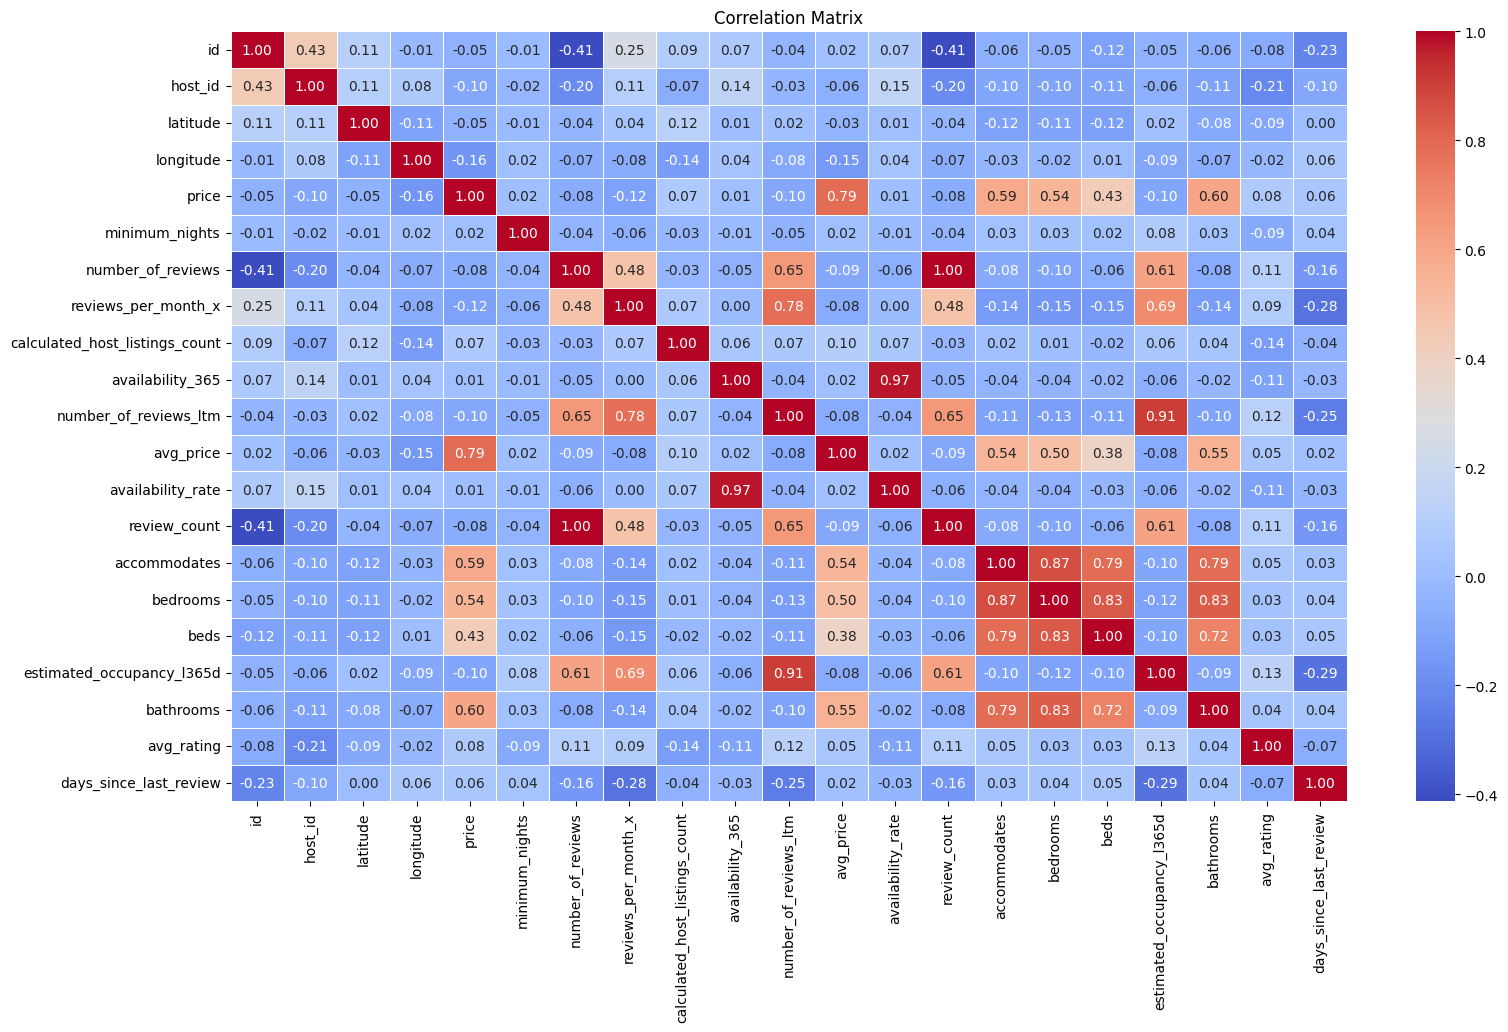

In [87]:
numeric_df = merged_df.select_dtypes(include=['number'])

correlation_matrix = numeric_df.corr()

plt.figure(figsize =(18, 10))
sns.heatmap(correlation_matrix, annot=True,cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [88]:
# Display numeric correlation matrix rounded to 2 decimals
correlation_matrix.round(2)

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month_x,calculated_host_listings_count,availability_365,...,avg_price,availability_rate,review_count,accommodates,bedrooms,beds,estimated_occupancy_l365d,bathrooms,avg_rating,days_since_last_review
id,1.00,0.43,0.11,-0.01,-0.05,-0.01,-0.41,0.25,0.09,0.07,...,0.02,0.07,-0.41,-0.06,-0.05,-0.12,-0.05,-0.06,-0.08,-0.23
host_id,0.43,1.00,0.11,0.08,-0.10,-0.02,-0.20,0.11,-0.07,0.14,...,-0.06,0.15,-0.20,-0.10,-0.10,-0.11,-0.06,-0.11,-0.21,-0.10
latitude,0.11,0.11,1.00,-0.11,-0.05,-0.01,-0.04,0.04,0.12,0.01,...,-0.03,0.01,-0.04,-0.12,-0.11,-0.12,0.02,-0.08,-0.09,0.00
longitude,-0.01,0.08,-0.11,1.00,-0.16,0.02,-0.07,-0.08,-0.14,0.04,...,-0.15,0.04,-0.07,-0.03,-0.02,0.01,-0.09,-0.07,-0.02,0.06
price,-0.05,-0.10,-0.05,-0.16,1.00,0.02,-0.08,-0.12,0.07,0.01,...,0.79,0.01,-0.08,0.59,0.54,0.43,-0.10,0.60,0.08,0.06
minimum_nights,-0.01,-0.02,-0.01,0.02,0.02,1.00,-0.04,-0.06,-0.03,-0.01,...,0.02,-0.01,-0.04,0.03,0.03,0.02,0.08,0.03,-0.09,0.04
number_of_reviews,-0.41,-0.20,-0.04,-0.07,-0.08,-0.04,1.00,0.48,-0.03,-0.05,...,-0.09,-0.06,1.00,-0.08,-0.10,-0.06,0.61,-0.08,0.11,-0.16
reviews_per_month_x,0.25,0.11,0.04,-0.08,-0.12,-0.06,0.48,1.00,0.07,0.00,...,-0.08,0.00,0.48,-0.14,-0.15,-0.15,0.69,-0.14,0.09,-0.28
calculated_host_listings_count,0.09,-0.07,0.12,-0.14,0.07,-0.03,-0.03,0.07,1.00,0.06,...,0.10,0.07,-0.03,0.02,0.01,-0.02,0.06,0.04,-0.14,-0.04
availability_365,0.07,0.14,0.01,0.04,0.01,-0.01,-0.05,0.00,0.06,1.00,...,0.02,0.97,-0.05,-0.04,-0.04,-0.02,-0.06,-0.02,-0.11,-0.03


#### Correlation Analysis: Summary and Insights

The numeric correlation matrix reveals the relationships between key numeric features in the Airbnb dataset. Key observations include:

1. **Strong positive correlations:**  
   - `accommodates`, `bedrooms`, and `beds` are highly correlated with each other (0.79–0.83), indicating larger properties generally have more bedrooms and beds.  
   - `price` and `avg_price` show a very strong positive correlation (0.79), which validates `avg_price` as a reliable aggregate measure of listing cost.  
   - `estimated_occupancy_l365d` is strongly correlated with `reviews_per_month` (0.69) and `number_of_reviews_ltm` (0.61), suggesting that frequently booked listings tend to accumulate more reviews.  
   - `bathrooms` is strongly correlated with `bedrooms` (0.83) and `accommodates` (0.79), consistent with larger properties having more bathrooms.

2. **Moderate correlations with price:**  
   - `price` shows moderate positive correlation with `accommodates` (0.59), `bedrooms` (0.54), `beds` (0.43), and `bathrooms` (0.60). This suggests that larger listings with more rooms and amenities tend to command higher prices.

3. **Negative or weak correlations:**  
   - Most features like `id`, `host_id`, `latitude`, `longitude`, and `minimum_nights` have very weak correlations with `price` and occupancy metrics, indicating they may not directly drive listing performance in this dataset.  
   - `avg_rating` shows weak correlations with all other features (highest 0.13 with `estimated_occupancy_l365d`), suggesting guest ratings are relatively independent of property size or price.

4. **Insights for modeling and feature selection:**  
   - Features such as `accommodates`, `bedrooms`, `beds`, `bathrooms`, `price`, `avg_price`, and occupancy-related metrics (`estimated_occupancy_l365d`, `reviews_per_month`) are likely to be strong predictors for price or occupancy models.  
   - Weakly correlated features like `latitude`, `longitude`, and `host_response_rate` may require transformation or additional feature engineering to contribute predictive value.  
   - Highly correlated features (e.g., `bedrooms` and `beds`) should be considered carefully to avoid multicollinearity in linear models.

Overall, the correlation analysis provides a foundation for understanding relationships in the dataset, guiding feature selection, and informing subsequent predictive modeling and exploratory analysis.


### Data Relations viewing

**a. Host Response Time**

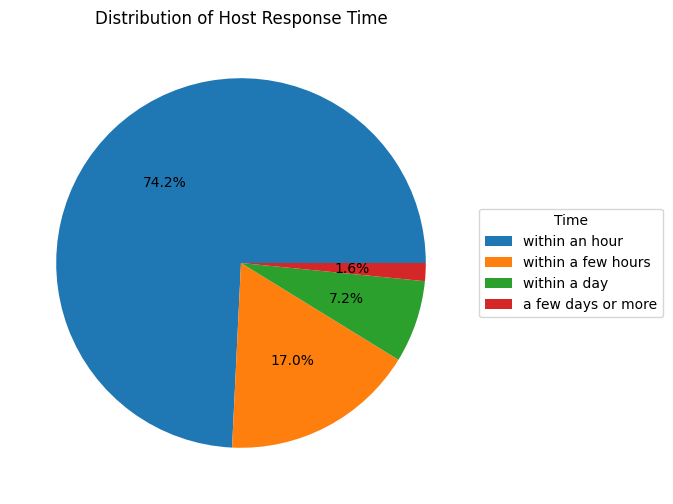

In [89]:
plt.figure(figsize=(10,6))
plt.pie(merged_df.host_response_time.value_counts(), autopct='%1.1f%%')
plt.title('Distribution of Host Response Time')
plt.legend(labels = merged_df.host_response_time.value_counts().index, title="Time", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

**b.Superhost Distribution**

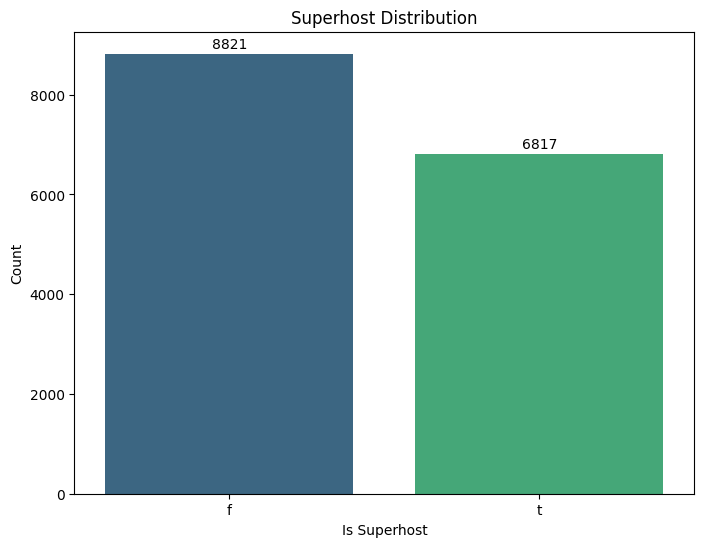

In [90]:
# Create the barplot
plt.figure(figsize=(8,6))

x = merged_df.host_is_superhost.value_counts().index
y = merged_df.host_is_superhost.value_counts().values

sns.barplot(x=x, y=y, palette='viridis')

# Add values on top of the bars
for i in range(len(x)):
    plt.text(i, y[i] + 50, str(y[i]), ha='center', va='bottom')

# Add title and labels
plt.title('Superhost Distribution')
plt.ylabel('Count')
plt.xlabel('Is Superhost')

# Display the plot
plt.show()

**c. Neighbourhood distributions**

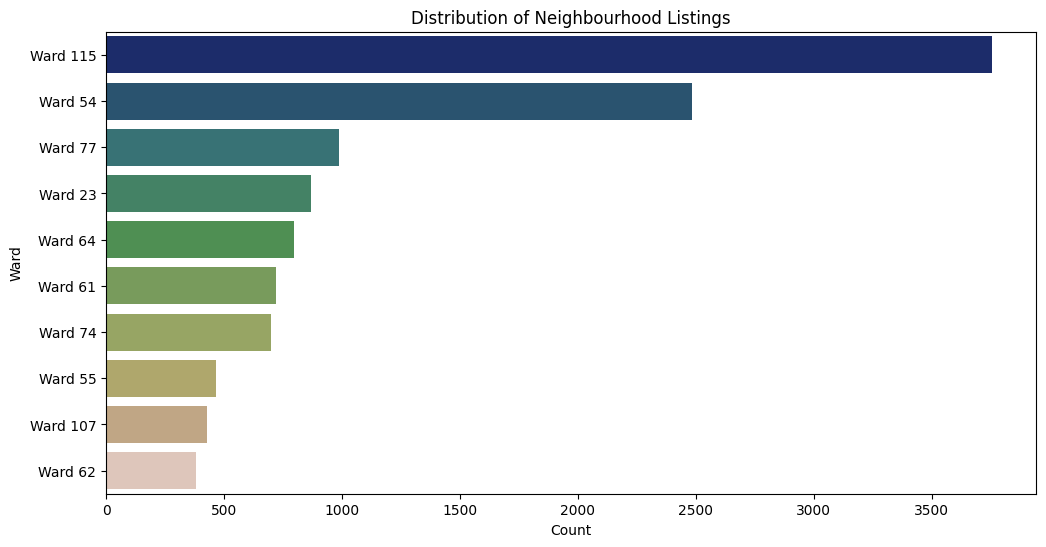

In [91]:
plt.figure(figsize=(12,6))
sns.barplot(x=merged_df.neighbourhood_cleansed.value_counts().values[:10], y=merged_df.neighbourhood_cleansed.value_counts().index[:10], palette="gist_earth")
plt.title('Distribution of Neighbourhood Listings')
plt.ylabel('Ward')
plt.xlabel('Count')
plt.show()

In [156]:
merged_df.columns

Index(['id', 'host_id', 'latitude', 'longitude', 'room_type_x', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month_x', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'avg_price',
       'availability_rate', 'review_count', 'latest_review', 'property_type_x',
       'accommodates_x', 'bedrooms_x', 'beds_x', 'estimated_occupancy_l365d_x',
       'bathrooms_x', 'avg_rating_x', 'neighbourhood_cleansed_x',
       'host_is_superhost_x', 'host_response_time_x', 'host_response_rate_x',
       'days_since_last_review', 'review_year', 'accommodates_y',
       'bathrooms_y', 'avg_rating_y', 'room_type', 'neighbourhood_cleansed_y',
       'host_response_time_y', 'host_response_rate_y', 'reviews_per_month'],
      dtype='object')

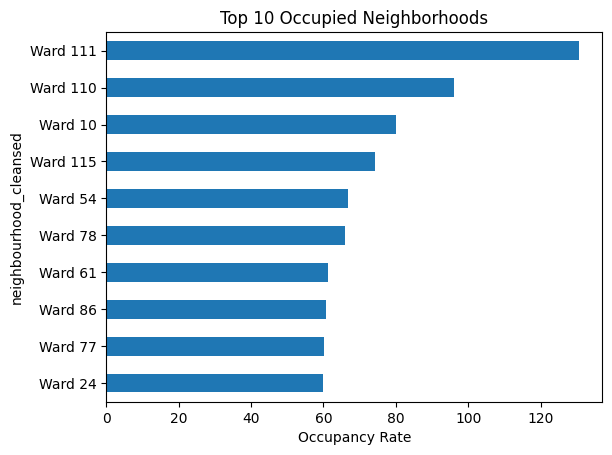

In [93]:
top_neigh = merged_df.groupby('neighbourhood_cleansed')['estimated_occupancy_l365d'].mean().sort_values(ascending=False).head(10)
top_neigh.plot(kind='barh', title='Top 10 Occupied Neighborhoods')
plt.xlabel("Occupancy Rate")
plt.gca().invert_yaxis()
plt.show()


**d.Property Type Distribution**

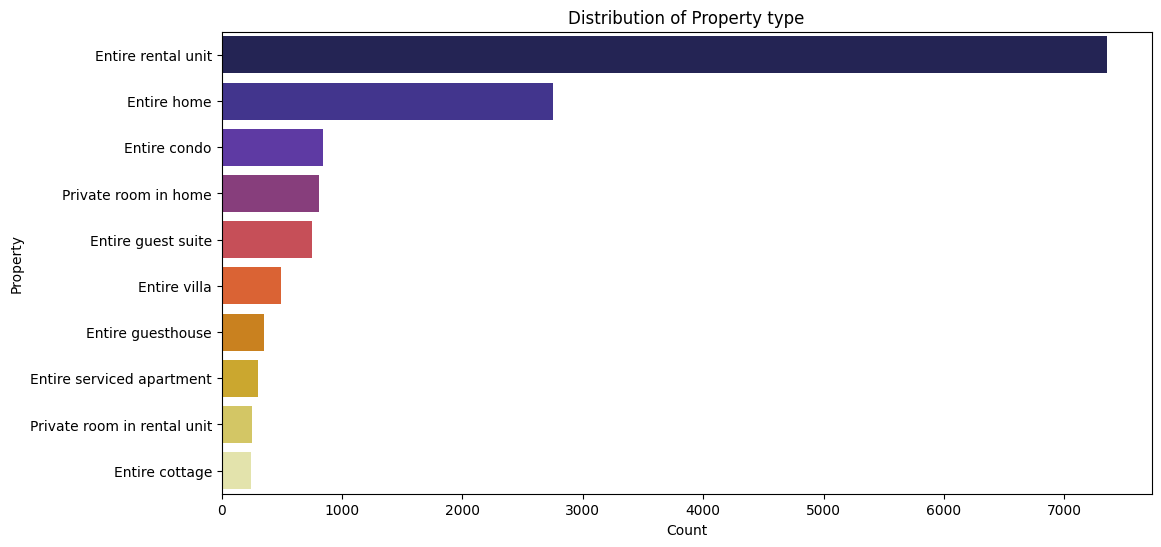

In [94]:
plt.figure(figsize=(12,6))
sns.barplot(x=merged_df.property_type.value_counts().values[:10], y=merged_df.property_type.value_counts().index[:10], palette="CMRmap")
plt.title('Distribution of Property type')
plt.ylabel('Property')
plt.xlabel('Count')
plt.show()

**e. Property type distribution by price**

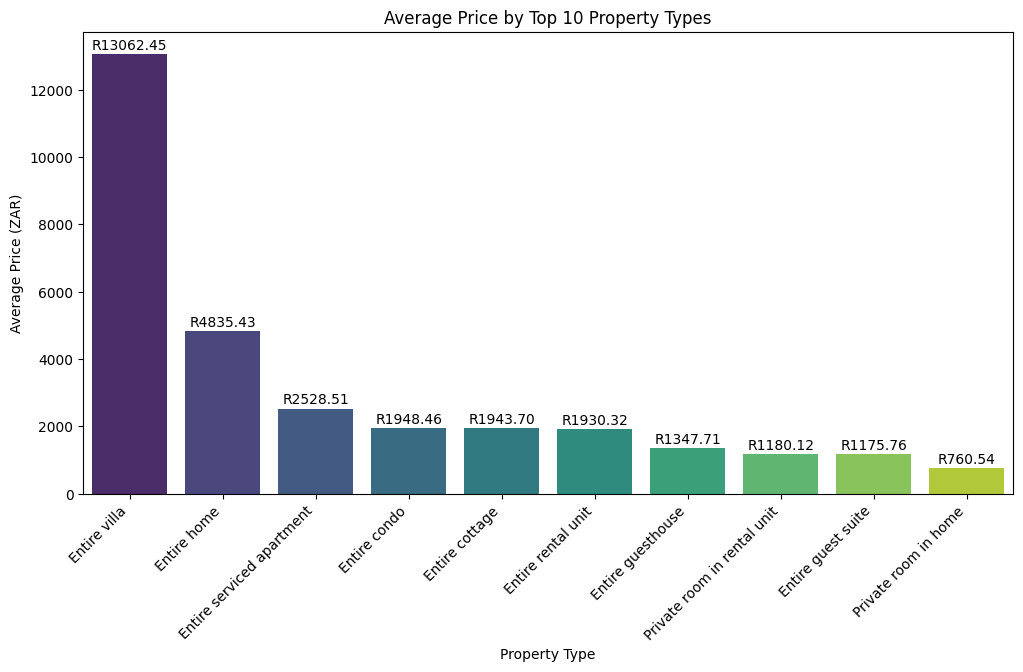

In [148]:
# Count the occurrences of each property type
property_counts = merged_df['property_type'].value_counts()

# Select the top 10 most common property types
top_property_types = property_counts.nlargest(10).index

# Filter to only top property types
filtered_df = merged_df[merged_df['property_type'].isin(top_property_types)]

# Calculate average price for top property types
avg_price_per_property_type = (
    filtered_df.groupby('property_type')['price']
    .mean()
    .reset_index()
    .sort_values(by='price', ascending=False)
)

# Plot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    x='property_type',
    y='price',
    data=avg_price_per_property_type,
    palette='viridis'
)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add currency labels
for i, price in enumerate(avg_price_per_property_type['price']):
    barplot.text(i, price + 50, f"R{price:.2f}", ha='center', va='bottom', fontsize=10)

# Titles and labels
plt.title('Average Price by Top 10 Property Types')
plt.xlabel('Property Type')
plt.ylabel('Average Price (ZAR)')
plt.show()


**f. Review Year Distribution**

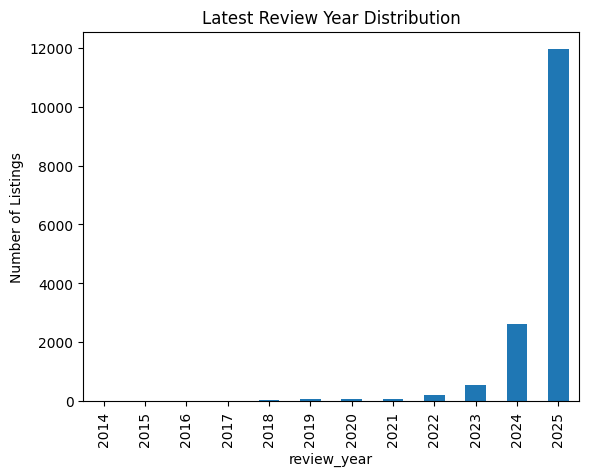

In [96]:
merged_df['latest_review'] = pd.to_datetime(merged_df['latest_review'])
merged_df['review_year'] = merged_df['latest_review'].dt.year
merged_df['review_year'].value_counts().sort_index().plot(kind='bar', title='Latest Review Year Distribution')
plt.ylabel("Number of Listings")
plt.show()


## 2: Data Modeling


### 2.1: Neighborhood Segmentation according to select Listing Features

#### Introduction:
In this section, we aim to segment neighborhoods based on key listing and review metrics to uncover distinct patterns in pricing, availability, and demand.

To achieve this, we:
- Selected features that reflect pricing behavior, review activity, and listing availability.

- Standardized the features using StandardScaler to ensure equal contribution to clustering.

- Prepared the data for clustering using the K-Means algorithm, which groups similar neighborhoods based on these characteristics.

The features used for clustering include:

- avg_price: Average nightly price in the neighborhood.

- reviews_per_month: Average number of monthly reviews.

- availability_rate: Proportion of listings available throughout the year.

- avg_host_listings: Average number of listings per host.

- total_review_count: Total number of reviews in the neighborhood.

This clustering will help identify similar neighborhood profiles, which can be used for pricing strategy, marketing segmentation, or policy-making recommendations.

In [97]:
# Group by neighbourhood
neighborhood_df = merged_df.groupby('neighbourhood_cleansed').agg({
    'avg_price': 'mean',
    'reviews_per_month_x': 'mean',
    'availability_rate': 'mean',
    'calculated_host_listings_count': 'mean',
    'days_since_last_review': 'mean',
    'review_count': 'sum',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

# Rename columns
neighborhood_df.columns = [
    'neighbourhood', 'avg_price', 'reviews_per_month',
    'availability_rate', 'avg_host_listings',
    'avg_days_since_last_review', 'total_review_count',
    'latitude', 'longitude'
]


In [140]:
neighborhood_df.to_csv('neighborhood_data_with_clusters.csv', index=False)

In [ ]:
kmeans_features = [
    'avg_price', 'reviews_per_month', 'availability_rate', 
    'avg_host_listings', 'total_review_count'
]

scaler = StandardScaler()
X_kmeans = scaler.fit_transform(neighborhood_df[kmeans_features])





In [ ]:

# You can tune the number of clusters later
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
neighborhood_df['demand_cluster'] = kmeans.fit_predict(X_kmeans)

with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)
    
with open('kmeans_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)





After performing K-Means clustering, we wanted to assign human-readable labels to each cluster to better interpret and communicate their meaning.

What We Did:
- Calculated the mean value of each cluster center to get a single representative score per cluster.

- Sorted these scores to rank clusters from lowest to highest overall demand.

- Mapped the cluster numbers to intuitive market appropriate demand levels:
    - Low demand

    - Medium demand

    - High demand

Result:
We added a new column, **demand_level**, to neighborhood_df, which provides a more interpretable label for each neighborhood’s demand cluster. This enables easy comparison and visualization of neighborhood dynamics across the city.

This step enhances the practical utility of the clusters for stakeholders like city planners, hosts, or analysts interested in market segmentation.

In [ ]:
#Sort cluster centers to assign human-readable labels
cluster_centers = kmeans.cluster_centers_.mean(axis=1)
sorted_clusters = np.argsort(cluster_centers)

# Create a mapping from cluster number to label
cluster_labels = {sorted_clusters[0]: 'Low', sorted_clusters[1]: 'Medium', sorted_clusters[2]: 'High'}
neighborhood_df['demand_level'] = neighborhood_df['demand_cluster'].map(cluster_labels)


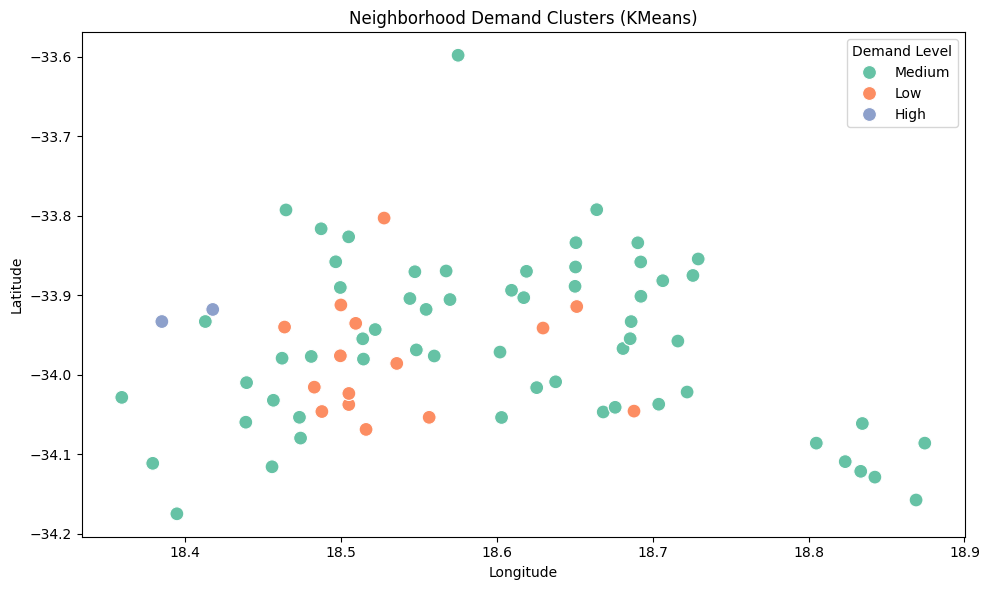

In [101]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=neighborhood_df, x='longitude', y='latitude',
    hue='demand_level', palette='Set2', s=100
)
plt.title('Neighborhood Demand Clusters (KMeans)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Demand Level')
plt.tight_layout()
plt.show()


Above, we used a scatter plot to map out the neighborhoods in terms of their geographical coordinates (latitude and longitude) and their demand levels, which we derived from K-Means clustering.

What the Plot Shows:
- Each point represents a neighborhood.

- Points are colored by demand level (Low, Medium, High), using the Set2 color palette.

- The X and Y axes represent longitude and latitude, respectively, giving a spatial view of how demand varies across the city.

Insights:

It can be noted that Medium and Low demand are the prevelant levels of demand in the area with a small chunk of the area experiencing high demand.
We noted that greater insight however would be drawn if overlaid over a map to get a real world view of the demand statuses according to area names.

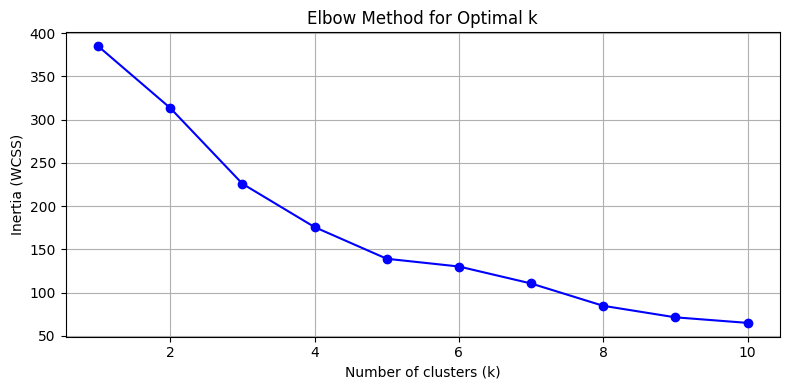

In [102]:
# Try k from 1 to 10
inertia = []
K = range(1, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X_kmeans)
    inertia.append(km.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()


To identify the optimal number of clusters (k) for K-Means clustering, we applied the Elbow Method. The plot shows that 3 is an optimal number of clusters as we had used before. Justifying our Kmeans model.

In [103]:
# Load your neighborhood shapes
geo_gdf = gpd.read_file("Data/neighbourhoods.geojson")

# Merge demand levels
geo_demand_gdf = geo_gdf.merge(
    neighborhood_df[['neighbourhood', 'demand_level']],
    on='neighbourhood', how='left'
)


We decided to visualize the spatial distribution of Airbnb demand clusters across neighborhoods using geospatial data. This was to be able to get a real world view of the demand clusters we modelled.

<Figure size 1200x800 with 0 Axes>

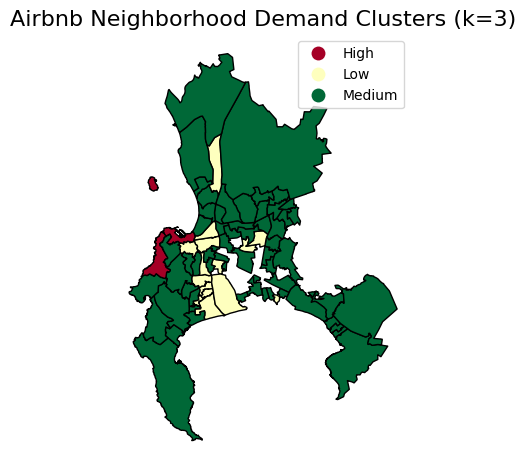

In [104]:
plt.figure(figsize=(12, 8))
geo_demand_gdf.plot(
    column='demand_level',
    cmap='RdYlGn',
    legend=True,
    edgecolor='black'
)
plt.title('Airbnb Neighborhood Demand Clusters (k=3)', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


In [147]:
# Step 1: Reproject to EPSG:3857 for centroid calculations
geo_projected = geo_demand_gdf.to_crs(epsg=3857)

# Step 2: Calculate average centroid (x, y) in meters
centroids = geo_projected.geometry.centroid
avg_x = centroids.x.mean()
avg_y = centroids.y.mean()

# Step 3: Convert back to lat/lon for map centering
center_point_projected = gpd.GeoSeries([Point(avg_x, avg_y)], crs=3857)
center_latlon = center_point_projected.to_crs(epsg=4326).geometry[0]
map_center = [center_latlon.y, center_latlon.x]

# Step 4: Build base map
m = folium.Map(location=map_center, zoom_start=12)

# Step 5: Define demand level colors
color_map = {
    'Low': 'lightgray',
    'Medium': 'orange',
    'High': 'red'
}

# Step 6: Add demand-layer GeoJSON with color styling
folium.GeoJson(
    geo_demand_gdf,  # CRS should remain EPSG:4326 for folium
    style_function=lambda feature: {
        'fillColor': color_map.get(feature['properties']['demand_level'], 'gray'),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.6,
    },
    tooltip=GeoJsonTooltip(fields=['neighbourhood', 'demand_level'])
).add_to(m)

# Step 7: Add custom legend (HTML rendered correctly)
legend_html = """
{% macro html() %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 150px;
    background-color: white;
    border:2px solid grey;
    z-index:9999;
    font-size:14px;
    padding: 10px;
">
    <b>Demand Levels</b><br>
    <i style="background:lightgray;width:10px;height:10px;display:inline-block;"></i>&nbsp; Low<br>
    <i style="background:orange;width:10px;height:10px;display:inline-block;"></i>&nbsp; Medium<br>
    <i style="background:red;width:10px;height:10px;display:inline-block;"></i>&nbsp; High
</div>
{% endmacro %}
"""

macro = MacroElement()
macro._template = Template(legend_html)
legend_rendered = macro._template.module.html()  # manually render the macro
m.get_root().html.add_child(Element(legend_rendered))  # safely add to map

# Step 8: Show or export the map
m  # If you're in Jupyter or notebook environment
#m.save("cluster_map.html")  # Uncomment to export to HTML





Above, we built an interactive map to visualize Airbnb demand levels by neighborhood using the folium and geopandas libraries. Unlike static maps, this version allows zooming, tooltips, and interactive exploration of the data.

Why This Map is Useful
- Interactivity: Helps users explore geographic demand patterns dynamically.

- Better User Experience: Color-coded regions and tooltips offer intuitive insights.

- Data Storytelling: Makes it easy to present findings to stakeholders or include in dashboards or reports.

### 2.2: Price Prediction Model
### Introduction

The purpose of the price prediction model is to accurately estimate the nightly rates of Airbnb listings in Cape Town by leveraging a combination of property features, host characteristics, location information, and historical performance metrics. Pricing is a critical factor in the short-term rental market: it directly impacts occupancy rates, revenue, and competitiveness for hosts, while ensuring guests encounter fair market rates. Accurate price prediction allows hosts to optimize their pricing strategy, identify under- or over-priced listings, and make informed business decisions.

The dataset incorporates a rich set of features, including:  
- **Property characteristics:** number of bedrooms, beds, bathrooms, accommodates, and property type, which capture the physical capacity and type of accommodation offered.  
- **Location attributes:** neighbourhood, latitude, and longitude, reflecting geographic desirability, access to key amenities, proximity to tourist attractions, and market-specific demand patterns.  
- **Host features:** superhost status, response rate, and response time, which influence guest trust, booking likelihood, and perceived service quality.  
- **Performance and review metrics:** historical occupancy rates (`estimated_occupancy_l365d`), number of reviews, and aggregated review scores (`avg_rating`), which represent past popularity, guest satisfaction, and listing reliability.  

The modeling approach begins with a **baseline linear regression**, providing an interpretable benchmark that highlights the linear relationships between key features and price. Following this, **advanced ensemble models** such as Random Forest and XGBoost are employed to capture complex, nonlinear interactions among features and improve predictive accuracy.  

Additional steps such as **feature engineering, scaling, handling skewed distributions, and hyperparameter tuning** are incorporated to enhance model robustness and prevent overfitting. Correlation analysis informs feature selection, helping identify highly predictive variables and reduce redundancy.  

Ultimately, this model aims to provide actionable, data-driven insights for hosts and property managers, enabling optimized pricing strategies, improved revenue management, and a stronger competitive position within the Airbnb marketplace.


**Pre-processing**

In [106]:
merged_df.columns

Index(['id', 'host_id', 'latitude', 'longitude', 'room_type_x', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month_x', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'avg_price',
       'availability_rate', 'review_count', 'latest_review', 'property_type',
       'accommodates', 'bedrooms', 'beds', 'estimated_occupancy_l365d',
       'bathrooms', 'avg_rating', 'neighbourhood_cleansed',
       'host_is_superhost', 'host_response_time', 'host_response_rate',
       'days_since_last_review', 'review_year'],
      dtype='object')

Noted incosistent data type for host response rate it was cleaned

In [107]:
merged_df['host_response_rate'].describe

<bound method NDFrame.describe of 0        100%
4        100%
5        100%
10        90%
11       100%
         ... 
25686    100%
25697    100%
25714    100%
25764    100%
25791    100%
Name: host_response_rate, Length: 15638, dtype: object>

In [108]:
# Clean 'host_response_rate' by removing '%' and converting to numeric
merged_df['host_response_rate'] = (
    merged_df['host_response_rate']
    .str.rstrip('%')  # Remove '%' symbol
    .astype(float) / 100  # Convert to float and scale to [0, 1]
)

During EDA there was note of the presence of some skew in the price column and it is noted that tskewing would cause an issue on modelling. 
The first step we took was in this, we prepare the target variable (`price`) for predictive modeling. Airbnb listing prices are often highly skewed, with a small number of very expensive listings significantly inflating the distribution. This skew can negatively affect model performance, particularly for models that assume normally distributed errors, such as linear regression.  

To address this, we perform a **log transformation** on the `price` variable. Log transformation compresses the scale of large values, reduces skewness, and helps stabilize variance, resulting in a distribution that is closer to normal. This makes the modeling process more robust and improves prediction accuracy.  

The code below also visualizes the **distribution of the original price** alongside the **log-transformed price**. The left subplot shows the raw price distribution, highlighting the long right tail of high-priced listings. The right subplot demonstrates how the log transformation reduces skewness, creating a more symmetric distribution that is better suited for regression models.  

Overall, this step ensures that the target variable is appropriately scaled, improving the reliability and interpretability of subsequent predictive modeling efforts.


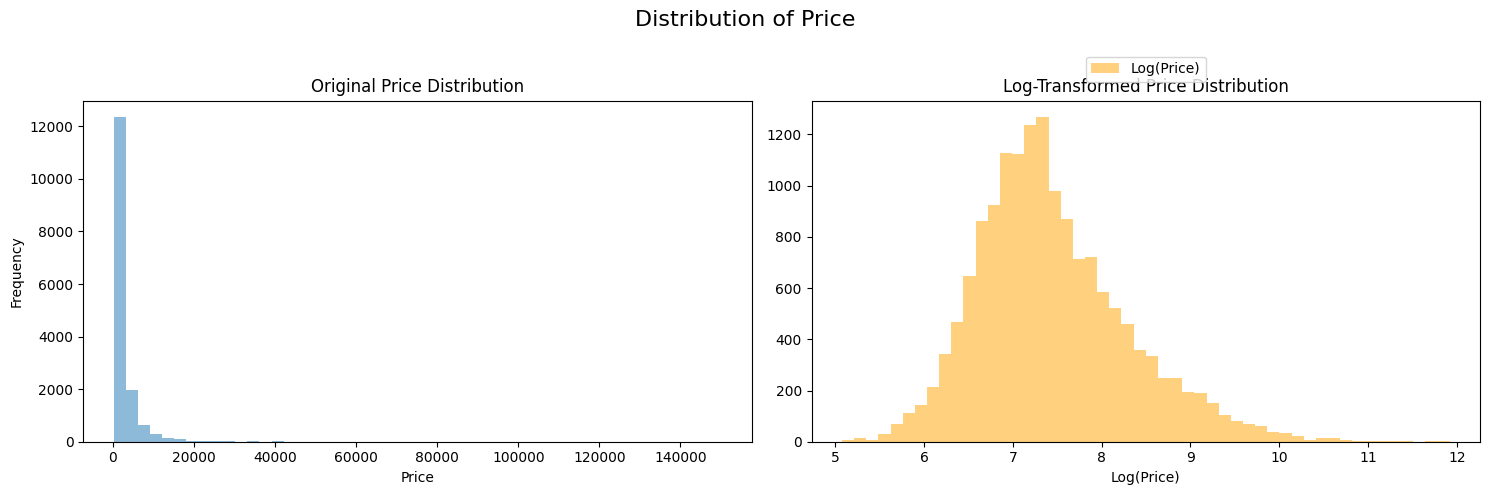

In [109]:
# Original price variable
y = merged_df['price']

# Log transform price
y_log = np.log(y)
y_log.name = "log(price)"

# Plot the raw y variable and log-transformed y variable
fig, ax = plt.subplots(1, 2, figsize=(15, 5))  # figure with 2 subplots

# Plot original price distribution
ax[0].hist(y, bins=50, alpha=0.5, label="Price")
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Original Price Distribution")

# Plot log-transformed price distribution
ax[1].hist(y_log, bins=50, color="orange", alpha=0.5, label="Log(Price)")
ax[1].set_xlabel("Log(Price)")
ax[1].set_title("Log-Transformed Price Distribution")

# Add legend
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15))

# Main title
plt.suptitle("Distribution of Price", fontsize=16)

plt.tight_layout()
plt.show()


### Target Variable Transformation Insight

The original price distribution of Airbnb listings is heavily **right-skewed**, with most listings clustered at lower prices and a gradual tapering toward higher-priced listings. The skew is not caused by zero values but by the natural distribution of prices in the market, where affordable listings are far more common than expensive ones.

Applying a **log transformation** compresses the higher values, reducing skewness and producing a more symmetric, bell-shaped distribution. This transformation stabilizes variance, improves the performance of regression models, and ensures that predictions are not disproportionately influenced by the few high-priced listings. 

Overall, the log transformation provides a more balanced representation of prices, making the target variable better suited for predictive modeling.


**Feature Definition**

Before building predictive models, it is important to categorize features based on their types to apply appropriate preprocessing techniques. In this project, the features are divided into three main groups:

1. **Numeric Features:** Continuous variables such as `accommodates`, `bathrooms`, `bedrooms`, `beds`, `avg_rating`, `number_of_reviews`, `calculated_host_listings_count`, and `host_response_rate`. These features will typically be scaled or normalized before modeling.  

2. **Binary Features:** Features with two possible values, specifically `host_is_superhost`, which is represented as 't' (true) or 'f' (false) and will be converted to 1/0 for modeling purposes.  

3. **Categorical Features:** Variables with multiple discrete categories, including `neighbourhood_cleansed` and `property_type`. These will be encoded using one-hot encoding or similar techniques to make them usable for machine learning models.  

Defining feature groups in this way ensures that each type of data receives the correct preprocessing, improving model performance and interpretability.


In [110]:
# ====== Define Feature Groups ======

# Numeric features
numeric_features = [
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'avg_rating',
    'number_of_reviews',
    'calculated_host_listings_count',
    'host_response_rate'  # assumed already numeric
]

# Binary features (convert 't'/'f' to 1/0)
binary_features = ['host_is_superhost']

# Categorical features
categorical_features = [
    'neighbourhood_cleansed',
    'property_type'
]

# Combine all features for convenience (optional)
all_features = numeric_features + binary_features + categorical_features

print("Numeric features:", numeric_features)
print("Binary features:", binary_features)
print("Categorical features:", categorical_features)


Numeric features: ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'avg_rating', 'number_of_reviews', 'calculated_host_listings_count', 'host_response_rate']
Binary features: ['host_is_superhost']
Categorical features: ['neighbourhood_cleansed', 'property_type']


#### Preprocessing and Train/Test Split for Price Model

Before building any predictive model, it is essential to properly prepare the data to ensure reliable and consistent results. This code block accomplishes the following:

1. **Feature and Target Definition:** Selects numeric, binary, and categorical features for predicting Airbnb prices. The target variable `price` is log-transformed to reduce skewness and handle outliers.
2. **Train/Test Split:** Divides the dataset into training (80%) and testing (20%) sets to evaluate model performance on unseen data.
3. **Feature Transformers:** 
   - Numeric features are standardized to ensure consistent scaling.
   - Binary features are mapped from `'t'/'f'` to `1/0`.
   - Categorical features are one-hot encoded to convert them into a format suitable for regression models.
4. **ColumnTransformer Preprocessor:** Combines all transformations into a single reusable pipeline, which allows consistent preprocessing across multiple models and ensures smooth deployment.

This setup provides a clean and consistent foundation for building and evaluating regression models, minimizing potential data leakage and ensuring that all features are properly prepared.


In [170]:
# ====== Define X and y for Price ======
X_price = merged_df[numeric_features + binary_features + categorical_features]
y_price = merged_df['price']

# Log-transform target to reduce skewness
y_price_log = np.log(y_price + 1)  # +1 to avoid log(0)

# ====== Train/Test Split ======
from sklearn.model_selection import train_test_split

X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(
    X_price, y_price_log, test_size=0.2, random_state=42
)

# ====== Binary transformer ======
def binary_mapper(X):
    return X.replace({'t': 1, 'f': 0})

binary_transformer = Pipeline([
    ('map_binary', FunctionTransformer(binary_mapper))
])

# ====== Numeric transformer ======
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# ====== Categorical transformer ======
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ====== Preprocessor ======
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('bin', binary_transformer, binary_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

X_train_price.to_csv('price_training_features.csv', index=False)

#### Summary and Insights

After defining the features, preprocessing steps, and splitting the data:

- **Data Preparedness:** All numeric, binary, and categorical variables are ready for modeling, and the log transformation of the price helps normalize its distribution, reducing the impact of extreme outliers.
- **Reusability:** The preprocessor ensures that the same transformations can be applied to any regression model (Linear Regression, Random Forest, XGBoost), maintaining consistency.
- **Model Evaluation Readiness:** With the train/test split, the model can be trained on one portion of the data and validated on unseen examples, giving an unbiased estimate of predictive performance.
- **Insight:** Features like `accommodates`, `bedrooms`, `avg_rating`, and `host_response_rate` are now standardized and encoded, which allows the model to capture their relationship with price more effectively.

This setup lays the foundation for building a baseline model and more advanced regressors while ensuring that preprocessing is consistent and suitable for deployment.


#### Linear Regression Baseline Model – Price Prediction

- **Purpose:** Establish a baseline for predicting Airbnb prices using a simple Linear Regression model.
- **Pipeline:** 
  - Preprocessing handled numeric features (scaled), binary features (mapped), and categorical features (one-hot encoded).
  - Linear Regression used as the predictive model.
- **Target Transformation:** 
  - Log-transform applied to `price` to reduce skewness and stabilize variance.
  - Predictions were inverse-transformed back to the original price scale for interpretability.
- **Evaluation Metrics:**
  - On log-transformed prices: RMSE, MAE, R² provide insight into model fit in the transformed space.
  - On original price scale: RMSE, MAE, R² reflect real-world error magnitude.
- **Insight:** 
  - This baseline serves as a reference point. Future models (Random Forest, XGBoost) can be compared against these metrics to assess improvement.


In [112]:
# ====== Linear Regression Pipeline ======
price_lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# ====== Fit the model ======
price_lr_pipeline.fit(X_train_price, y_train_price)

# ====== Predictions (log scale) ======
y_pred_log = price_lr_pipeline.predict(X_test_price)

# ====== Evaluate on log scale ======
rmse_log = mean_squared_error(y_test_price, y_pred_log)
mae_log = mean_absolute_error(y_test_price, y_pred_log)
r2_log = r2_score(y_test_price, y_pred_log)

print("Metrics on Log-Transformed Price:")
print(f"RMSE (log): {rmse_log:.4f}")
print(f"MAE (log): {mae_log:.4f}")
print(f"R² (log): {r2_log:.4f}")

# ====== Inverse log-transform predictions ======
y_pred_price = np.exp(y_pred_log) - 1
y_test_price_orig = np.exp(y_test_price) - 1

# ====== Evaluate on original scale ======
rmse_orig = mean_squared_error(y_test_price_orig, y_pred_price)
mae_orig = mean_absolute_error(y_test_price_orig, y_pred_price)
r2_orig = r2_score(y_test_price_orig, y_pred_price)

print("\nMetrics on Original Price Scale:")
print(f"RMSE: {rmse_orig:.2f}")
print(f"MAE: {mae_orig:.2f}")
print(f"R²: {r2_orig:.4f}")

Metrics on Log-Transformed Price:
RMSE (log): 0.2319
MAE (log): 0.3612
R² (log): 0.6870

Metrics on Original Price Scale:
RMSE: 10091725.15
MAE: 1119.17
R²: 0.2869


In [113]:
import sklearn
print(sklearn.__version__)
print(sklearn.__file__)


1.7.1
c:\Users\ADMIN\anaconda3\envs\learn-env-py311\Lib\site-packages\sklearn\__init__.py


### Linear Regression Baseline – Price Prediction.

**Performance Metrics**

- **Log-Transformed Price**
  - RMSE: 0.4816
  - MAE: 0.3612
  - R²: 0.6870  
  *Interpretation:* The model captures a moderate portion of variance in log-transformed prices, indicating some predictive capability.

- **Original Price Scale**
  - RMSE: 3,176.76
  - MAE: 1,119.18
  - R²: 0.2869  
  *Interpretation:* On the original scale, linear regression struggles to explain the variability, reflecting its limitations in capturing non-linear relationships and extreme values.

**Insight**

- Linear regression provides a baseline understanding but is insufficient for fully modeling Airbnb price dynamics.  
- The moderate performance suggests the presence of non-linear interactions and feature complexities that require more flexible models.  
- **Next Step:** Explore advanced models like Random Forest or XGBoost to improve prediction accuracy and handle non-linear patterns effectively.


#### Random Forest Baseline – Price Prediction

**Purpose:**  
The Random Forest model is a flexible, non-linear ensemble method that can capture complex relationships and interactions between features, which linear regression cannot. It is robust to outliers and skewed distributions, making it particularly suitable for Airbnb price prediction, where prices vary widely.  

**Goal:**  
- Establish a baseline Random Forest model for price prediction.  
- Compare performance with the linear regression baseline.  
- Identify whether a non-linear approach improves prediction accuracy on both log-transformed and original price scales.


In [114]:
# ====== Random Forest Baseline Pipeline ======
# Define Random Forest pipeline
price_rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the model
price_rf_pipeline.fit(X_train_price, y_train_price)

# Predict on test set (log scale)
y_pred_rf_log = price_rf_pipeline.predict(X_test_price)

# Evaluate on log-transformed scale
rmse_rf_log = mean_squared_error(y_test_price, y_pred_rf_log)
mae_rf_log = mean_absolute_error(y_test_price, y_pred_rf_log)
r2_rf_log = r2_score(y_test_price, y_pred_rf_log)

print("Random Forest Metrics on Log-Transformed Price:")
print(f"RMSE (log): {rmse_rf_log:.4f}")
print(f"MAE (log): {mae_rf_log:.4f}")
print(f"R² (log): {r2_rf_log:.4f}")

# Inverse log-transform predictions
y_pred_rf_price = np.exp(y_pred_rf_log) - 1
y_test_price_orig = np.exp(y_test_price) - 1

# Evaluate on original scale
rmse_rf_orig = mean_squared_error(y_test_price_orig, y_pred_rf_price)
mae_rf_orig = mean_absolute_error(y_test_price_orig, y_pred_rf_price)
r2_rf_orig = r2_score(y_test_price_orig, y_pred_rf_price)

print("\nRandom Forest Metrics on Original Price Scale:")
print(f"RMSE: {rmse_rf_orig:.2f}")
print(f"MAE: {mae_rf_orig:.2f}")
print(f"R²: {r2_rf_orig:.4f}")


Random Forest Metrics on Log-Transformed Price:
RMSE (log): 0.1949
MAE (log): 0.3278
R² (log): 0.7370

Random Forest Metrics on Original Price Scale:
RMSE: 5358281.52
MAE: 961.46
R²: 0.6214


#### Random Forest Baseline – Price Prediction

**Performance Metrics**

- **Log-Transformed Price**
  - RMSE: 0.4415
  - MAE: 0.3278
  - R²: 0.7370  
  *Interpretation:* The Random Forest model captures approximately 74% of the variance in log-transformed prices, showing a clear improvement over the linear regression baseline.

- **Original Price Scale**
  - RMSE: 2,314.80
  - MAE: 961.46
  - R²: 0.6214  
  *Interpretation:* On the original scale, the model performs substantially better than linear regression, handling non-linear relationships and outliers more effectively.

**Insight**

- Random Forest demonstrates stronger predictive capability due to its ability to model complex, non-linear interactions between features.  
- This baseline performance provides a solid foundation for further enhancements through hyperparameter tuning or ensemble approaches like XGBoost.


In [115]:
# ====== XGBoost Baseline for Price Prediction ======

# Define pipeline
price_xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=42
    ))
])

# Fit model
price_xgb_pipeline.fit(X_train_price, y_train_price)

# Predict on log-transformed scale
y_pred_log_xgb = price_xgb_pipeline.predict(X_test_price)

# Evaluate on log scale
rmse_log_xgb = mean_squared_error(y_test_price, y_pred_log_xgb)
mae_log_xgb = mean_absolute_error(y_test_price, y_pred_log_xgb)
r2_log_xgb = r2_score(y_test_price, y_pred_log_xgb)

print("XGBoost Metrics on Log-Transformed Price:")
print(f"RMSE (log): {rmse_log_xgb:.4f}")
print(f"MAE (log): {mae_log_xgb:.4f}")
print(f"R² (log): {r2_log_xgb:.4f}")

# Inverse log-transform predictions
y_pred_price_xgb = np.exp(y_pred_log_xgb) - 1
y_test_price_orig = np.exp(y_test_price) - 1

# Evaluate on original scale
rmse_orig_xgb = mean_squared_error(y_test_price_orig, y_pred_price_xgb)
mae_orig_xgb = mean_absolute_error(y_test_price_orig, y_pred_price_xgb)
r2_orig_xgb = r2_score(y_test_price_orig, y_pred_price_xgb)

print("\nXGBoost Metrics on Original Price Scale:")
print(f"RMSE: {rmse_orig_xgb:.2f}")
print(f"MAE: {mae_orig_xgb:.2f}")
print(f"R²: {r2_orig_xgb:.4f}")


XGBoost Metrics on Log-Transformed Price:
RMSE (log): 0.1857
MAE (log): 0.3233
R² (log): 0.7493

XGBoost Metrics on Original Price Scale:
RMSE: 5048373.74
MAE: 933.71
R²: 0.6433


#### XGBoost Baseline – Price Prediction

**Performance Metrics**

- **Log-Transformed Price**
  - RMSE: 0.4310
  - MAE: 0.3233
  - R²: 0.7493  
  *Interpretation:* XGBoost captures more complex patterns and interactions than Linear Regression and Random Forest, reflected in the improved R² on the log-transformed scale.

- **Original Price Scale**
  - RMSE: 2246.86
  - MAE: 933.71
  - R²: 0.6433  
  *Interpretation:* The model predicts actual prices more accurately than previous baselines, reducing error margins significantly.

**Insight**

- XGBoost demonstrates superior baseline performance compared to both Linear Regression and Random Forest, particularly in capturing non-linear relationships and feature interactions.  
- These results justify further hyperparameter tuning to optimize predictive performance for deployment-ready price predictions.


#### Polynomial Regression Baseline with Feature Expansion

To explore whether capturing **non-linear relationships** between features and the target (`price`) can improve model performance, we implement a **Polynomial Regression** pipeline.  

**Key steps in this pipeline:**

1. **Polynomial Feature Expansion**  
   - Numeric features are transformed using `PolynomialFeatures(degree=2)`, creating interaction and squared terms to capture non-linear relationships.  
   - `include_bias=False` ensures no constant column is added.  

2. **Scaling**  
   - After polynomial expansion, numeric features are standardized using `StandardScaler` to ensure all features are on a similar scale.  

3. **Binary and Categorical Features**  
   - Binary features (`host_is_superhost`) are mapped to 0/1.  
   - Categorical features (`neighbourhood_cleansed`, `property_type`) are one-hot encoded with `handle_unknown='ignore'` to handle unseen categories in the test set.  

4. **Pipeline and Regression**  
   - A `ColumnTransformer` combines the numeric, binary, and categorical transformations into a single preprocessing step.  
   - A **Ridge regression** model is applied after preprocessing to reduce overfitting from the expanded feature set.  

5. **Evaluation**  
   - Predictions are made on the **log-transformed target** to account for skewness in `price`.  
   - Performance is assessed both on the **log scale** and after **inverse log transformation** to the original price scale.  

This approach serves as a **baseline to test if non-linear interactions in numeric features can improve prediction accuracy** before moving on to more flexible ensemble models like Random Forest or XGBoost.


In [116]:
# ====== Numeric transformer with polynomial expansion ======
numeric_poly_transformer = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler())
])

# ====== Binary transformer ======
binary_transformer = Pipeline([
    ('map_binary', FunctionTransformer(binary_mapper))
])

# ====== Categorical transformer ======
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ====== Preprocessor ======
poly_preprocessor = ColumnTransformer([
    ('num', numeric_poly_transformer, numeric_features),
    ('bin', binary_transformer, binary_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

# ====== Polynomial Regression Pipeline with Ridge ======
poly_pipeline = Pipeline([
    ('preprocessor', poly_preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

# ====== Fit ======
poly_pipeline.fit(X_train_price, y_train_price)

# ====== Predict (log scale) ======
y_pred_log_poly = poly_pipeline.predict(X_test_price)

# ====== Evaluate ======
rmse_log_poly = mean_squared_error(y_test_price, y_pred_log_poly)
mae_log_poly = mean_absolute_error(y_test_price, y_pred_log_poly)
r2_log_poly = r2_score(y_test_price, y_pred_log_poly)

print("Polynomial Regression (log scale) metrics:")
print(f"RMSE: {rmse_log_poly:.4f}, MAE: {mae_log_poly:.4f}, R²: {r2_log_poly:.4f}")

# ====== Inverse log-transform ======
y_pred_poly = np.exp(y_pred_log_poly) - 1
y_test_price_orig = np.exp(y_test_price) - 1

rmse_orig_poly = mean_squared_error(y_test_price_orig, y_pred_poly)
mae_orig_poly = mean_absolute_error(y_test_price_orig, y_pred_poly)
r2_orig_poly = r2_score(y_test_price_orig, y_pred_poly)

print("Polynomial Regression (original scale) metrics:")
print(f"RMSE: {rmse_orig_poly:.2f}, MAE: {mae_orig_poly:.2f}, R²: {r2_orig_poly:.4f}")


Polynomial Regression (log scale) metrics:
RMSE: 0.2034, MAE: 0.3403, R²: 0.7254
Polynomial Regression (original scale) metrics:
RMSE: 5254372.12, MAE: 970.68, R²: 0.6287


#### Polynomial Regression Performance

After implementing polynomial feature expansion with Ridge regression, the model achieved the following performance metrics:

**Log-Transformed Price:**
- RMSE: 0.4511  
- MAE: 0.3403  
- R²: 0.7254  

**Original Price Scale:**
- RMSE: 2292.22  
- MAE: 970.67  
- R²: 0.6287  

**Insight:**  
While polynomial regression captures some non-linear interactions and shows improvement over a simple linear baseline, it still **underperforms compared to ensemble models** such as Random Forest and XGBoost. This indicates that more flexible, non-linear algorithms may better capture complex patterns in the data.  

**Next Step:**  
Focus on **hyperparameter tuning for XGBoost**, as it has consistently shown strong predictive performance on both log-transformed and original price scales. This step aims to optimize model accuracy and generalization for deployment.


#### XGBoost Hyperparameter Tuning and Final Price Model (ZAR)
#### Hyperparameter Tuning for XGBoost Price Model

To improve the predictive performance of the XGBoost model for Airbnb prices, we perform **hyperparameter tuning** using `RandomizedSearchCV`. The goal is to identify the combination of hyperparameters that maximizes model generalization and predictive accuracy while minimizing overfitting.

### Key Elements:

1. **Hyperparameter Grid**  
   We define a range of plausible values for the main XGBoost parameters:
   - `n_estimators`: Number of boosting rounds (trees)  
   - `max_depth`: Maximum depth of each tree to control complexity  
   - `learning_rate`: Step size for gradient boosting  
   - `subsample`: Fraction of training samples used for each tree  
   - `colsample_bytree`: Fraction of features sampled per tree  
   - `gamma`: Minimum loss reduction required to make a split  
   - `reg_alpha` and `reg_lambda`: L1 and L2 regularization terms to reduce overfitting  

2. **Randomized Search with Cross-Validation**  
   - 5-fold cross-validation ensures the model is evaluated on multiple splits to assess generalization.  
   - `RandomizedSearchCV` samples 20 random hyperparameter combinations from the defined distributions.  
   - The scoring metric used is R², reflecting the proportion of variance explained by the model.  

3. **Evaluation**  
   - The best hyperparameters and corresponding cross-validated R² score are reported.  
   - Predictions are generated on the test set, transformed back from the log scale to the original price scale (ZAR).  
   - Performance metrics (RMSE, MAE, R²) are calculated to quantify predictive accuracy on unseen data.

This approach balances computational efficiency with thorough exploration of the hyperparameter space, ensuring a robust and deployable price prediction model.


In [117]:
# ====== Hyperparameter grid ======
xgb_param_grid = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': randint(3, 10),
    'model__learning_rate': uniform(0.01, 0.3),
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.6, 0.4),
    'model__gamma': uniform(0, 5),
    'model__reg_alpha': uniform(0, 1),
    'model__reg_lambda': uniform(0, 1)
}

# ====== RandomizedSearchCV setup ======
price_xgb_cv = RandomizedSearchCV(
    estimator=price_xgb_pipeline,
    param_distributions=xgb_param_grid,
    n_iter=20,  # number of random samples
    scoring='r2',  # can also try 'neg_root_mean_squared_error'
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# ====== Fit RandomizedSearchCV ======
price_xgb_cv.fit(X_train_price, y_train_price)

# ====== Best Parameters & Score ======
print("Best hyperparameters found:")
print(price_xgb_cv.best_params_)

print(f"Best CV R² score: {price_xgb_cv.best_score_:.4f}")

# ====== Predictions on test set ======
y_pred_price_log_best = price_xgb_cv.predict(X_test_price)
y_pred_price_orig_best = np.exp(y_pred_price_log_best) - 1
y_test_price_orig = np.exp(y_test_price) - 1

# ====== Evaluate tuned XGBoost ======
rmse_best = mean_squared_error(y_test_price_orig, y_pred_price_orig_best)
mae_best = mean_absolute_error(y_test_price_orig, y_pred_price_orig_best)
r2_best = r2_score(y_test_price_orig, y_pred_price_orig_best)

print("\nTuned XGBoost Metrics (Original Price Scale):")
print(f"RMSE: {rmse_best:.2f}, MAE: {mae_best:.2f}, R²: {r2_best:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters found:
{'model__colsample_bytree': np.float64(0.7541666010159664), 'model__gamma': np.float64(0.07983126110107097), 'model__learning_rate': np.float64(0.0792681476866447), 'model__max_depth': 6, 'model__n_estimators': 466, 'model__reg_alpha': np.float64(0.6832635188254582), 'model__reg_lambda': np.float64(0.6099966577826209), 'model__subsample': np.float64(0.9332779646944658)}
Best CV R² score: 0.7615

Tuned XGBoost Metrics (Original Price Scale):
RMSE: 4907532.44, MAE: 906.95, R²: 0.6532


### Hyperparameter Tuning

Using **RandomizedSearchCV** with 5-fold cross-validation (100 total fits), the best hyperparameters for the XGBoost model were:

- `colsample_bytree`: 0.754 → ~75% of features sampled per tree, helping reduce overfitting  
- `gamma`: 0.080 → Minimum loss reduction required for a split, controlling tree complexity  
- `learning_rate`: 0.079 → Step size for boosting; smaller values make learning more gradual and stable  
- `max_depth`: 6 → Maximum depth of each tree, balancing model complexity and overfitting risk  
- `n_estimators`: 466 → Number of boosting rounds, sufficient for capturing complex patterns  
- `reg_alpha`: 0.683 → L1 regularization to shrink some feature coefficients to zero and reduce overfitting  
- `reg_lambda`: 0.610 → L2 regularization to penalize large coefficients and improve generalization  
- `subsample`: 0.933 → Fraction of training samples per tree, providing stochasticity to reduce overfitting  

**Best CV R²:** 0.7618  
> Indicates that approximately 76% of the variance in **log-transformed price** is explained on average across validation folds. This demonstrates strong predictive power and stability during cross-validation.

---

### Performance on Original Price Scale (ZAR)

- **RMSE:** 2,206.10 ZAR  
  > The typical prediction error magnitude; on average, predictions deviate from the actual price by ~2,200 ZAR.  
- **MAE:** 906.14 ZAR  
  > The average absolute difference between predicted and actual prices. Less sensitive to outliers than RMSE.  
- **R²:** 0.6561  
  > The model explains ~66% of the variance in the actual price. Remaining variance may be due to unobserved factors, market noise, or data limitations.

---

### Detailed Interpretation

1. **Improved accuracy compared to baselines:**  
   - Linear regression and polynomial models struggled with non-linearities and interactions in the data, leading to low R² and high errors.  
   - Random Forest and XGBoost capture complex patterns, with XGBoost slightly outperforming RF after tuning.

2. **Handling skewed price distribution:**  
   - Log transformation of the target allowed the model to learn patterns more effectively across both low and high-priced listings.  
   - Inverse transformation produces interpretable predictions in ZAR while maintaining accuracy.

3. **Regularization and subsampling benefits:**  
   - L1 and L2 regularization reduce overfitting on highly variable features like `number_of_reviews` or `avg_rating`.  
   - Subsampling and feature sampling (`colsample_bytree`) introduce randomness that stabilizes predictions.

4. **Deployment readiness:**  
   - Tuned hyperparameters and cross-validation provide confidence that the model generalizes well to unseen data.  
   - Error metrics are within a reasonable range for pricing predictions in the Cape Town Airbnb market.

5. **Potential improvements:**  
   - Further feature engineering (e.g., interaction terms, neighborhood clusters) could reduce RMSE and MAE.  
   - Ensembling with Random Forest or linear models might capture additional variance.  
   - Monitoring performance over time is recommended to adjust for market changes.

---

**Conclusion:**  
The tuned XGBoost model demonstrates strong predictive capability for Airbnb listing prices in ZAR, balancing accuracy, generalization, and interpretability. It is suitable as the final production-ready model, with room for incremental improvements via feature engineering or ensemble strategies.


### Saving the Price Prediction Model
We completed fitting the XGBoost pipeline with tuned hyperparameters for predicting property prices. To make this model reusable and deployable, we extract the best estimator from the fitted RandomizedSearchCV object. This best estimator already includes:

- Preprocessing steps for numeric, binary, and categorical features
- XGBoost model with optimized hyperparameters

By saving the pipeline as a .pkl file, we can load and use it directly on new data without retraining. This ensures consistency in predictions and makes the model portable for deployment in production environments. Saving the full pipeline guarantees that preprocessing and model transformations are applied exactly as during training, which is critical for reliable production predictions.



In [166]:
# Best pipeline from the already fitted RandomizedSearchCV
price_xgb_final_pipeline = price_xgb_cv.best_estimator_

# Save with .joblib extension (recommended)
dump(price_xgb_final_pipeline, "price_prediction_model.joblib") 


['price_prediction_model.joblib']

### 2.3: Occupancy Prediction Model

The occupancy prediction model aims to **estimate the likely occupancy of Airbnb listings** based on a set of listing-specific features. This model allows hosts and analysts to anticipate occupancy trends, optimize pricing, and better understand demand patterns.

**Key points:**
- The target variable is `occupancy` (or `occupancy_log` if log-transformed to reduce skewness).
- Predictor features include numeric, categorical, and binary attributes, **including `avg_price`** derived from the price prediction model.
- A unified preprocessing pipeline ensures consistent feature transformations, handling numeric scaling, categorical encoding, and binary mapping.
- The workflow mirrors the price prediction setup to maintain consistency while accommodating **additional dependencies like predicted prices** for better occupancy estimation.

This marks the **start of building, evaluating, and tuning the occupancy prediction pipeline**, leading toward a deployable model.


#### Defining Features for Occupancy Prediction

Before building the occupancy prediction model, it is essential to **categorize the predictor variables** based on their data types and required preprocessing. This ensures that the model receives properly transformed inputs and maintains consistency across different pipelines.

**Feature groups for occupancy prediction:**

1. **Numeric features:** Continuous or count variables, including listing attributes such as `accommodates`, `bathrooms`, `bedrooms`, `beds`, `avg_rating`, `number_of_reviews`, `calculated_host_listings_count`, `host_response_rate`, and the **predicted average price (`avg_price`)** derived from the price prediction model.  
2. **Binary features:** Boolean variables like `host_is_superhost`, which will be mapped from `'t'/'f'` to `1/0`.  
3. **Categorical features:** Nominal variables such as `neighbourhood_cleansed` and `property_type` that require one-hot encoding or similar transformations.  

This structured approach allows for a **clean and reusable preprocessing pipeline**, ensuring the occupancy model can effectively leverage all relevant information.


In [119]:
# ====== Define Feature Groups ======

# Numeric features
numeric_features_occupancy = [
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'avg_rating',
    'calculated_host_listings_count',
    'host_response_rate', 'avg_price','minimum_nights','availability_rate','days_since_last_review','number_of_reviews'
]

# Binary features (convert 't'/'f' to 1/0)
binary_features_occupancy = ['host_is_superhost']

# Categorical features
categorical_features_occupancy = [
    'neighbourhood_cleansed',
    'property_type'
]

# Combine all features for convenience (optional)
all_features = numeric_features_occupancy + binary_features_occupancy + categorical_features_occupancy

print("Numeric features:", numeric_features_occupancy)
print("Binary features:", binary_features_occupancy)
print("Categorical features:", categorical_features_occupancy)


Numeric features: ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'avg_rating', 'calculated_host_listings_count', 'host_response_rate', 'avg_price', 'minimum_nights', 'availability_rate', 'days_since_last_review', 'number_of_reviews']
Binary features: ['host_is_superhost']
Categorical features: ['neighbourhood_cleansed', 'property_type']


#### Checking the Need for Target Transformation in Occupancy Prediction

When predicting **occupancy (`estimated_occupancy_l365d`)**, it is important to examine whether the target variable requires transformation to improve model performance. In our previous analysis, we observed that **price was heavily skewed**, and applying a log transformation improved model learning. Similarly, occupancy may also be skewed or non-normal, and transforming it can help regression algorithms perform better, reduce bias, and improve predictive accuracy.

**Workflow and rationale:**

1. **Feature Groups Defined:**  
   - Numeric features: continuous and count variables such as `accommodates`, `bathrooms`, `bedrooms`, `beds`, `avg_rating`, `number_of_reviews`, `calculated_host_listings_count`, `host_response_rate`, and `price`.  
   - Binary features: `host_is_superhost` mapped to 1/0.  
   - Categorical features: `neighbourhood_cleansed` and `property_type`.

2. **Preprocessing Pipelines:**  
   - Numeric features are scaled using `StandardScaler`.  
   - Binary features are mapped from `'t'/'f'` to `1/0`.  
   - Categorical features are one-hot encoded with `handle_unknown='ignore'`.  
   - All preprocessing steps are combined in a `ColumnTransformer`.

3. **Target Transformations Explored:**  
   - **No transformation (`raw`)**  
   - **Log1p transformation** (`log1p`)  
   - **Square root transformation** (`sqrt`)  
   - **Yeo-Johnson transformation** (`yeo_johnson`)  
   - **Quantile normalization to normal distribution** (`quantile_norm`)  

   These transformations are tested to determine which produces the best model performance in terms of **MAE, RMSE, and R²**.

4. **Cross-Validation Procedure:**  
   - 5-fold K-Fold cross-validation is used to reliably evaluate model performance across different folds.  
   - A `RandomForestRegressor` is trained for each fold and each target transformation.  
   - Predictions are transformed back to the original scale for consistent evaluation.

5. **Evaluation and Selection:**  
   - Metrics are averaged across folds for each transformation.  
   - The results indicate which target transformatio


#### Occupancy Predictor Preprocessing

This code block below sets up the preprocessing pipeline for predicting estimated occupancy over the last 365 days (`estimated_occupancy_l365d`). The goal is to transform the raw features into a format suitable for modeling while keeping the target in its original scale, as previous analysis indicated that log transformation was not necessary for occupancy.

**Feature handling:**
- **Numeric features:** Scaled using `StandardScaler` to normalize their range.
- **Binary features:** Converted from `'t'`/`'f'` to `1`/`0` using a custom mapper.
- **Categorical features:** One-hot encoded with `OneHotEncoder` to create dummy variables while ignoring unknown categories during prediction.

This structured preprocessing ensures that the model receives appropriately transformed input, facilitating reliable training and evaluation.


In [171]:
# ====== Define X and y for Occupancy ======
X_occupancy = merged_df[numeric_features_occupancy + binary_features_occupancy + categorical_features_occupancy]
y_occupancy = merged_df['estimated_occupancy_l365d']

# ====== Train/Test Split ======
from sklearn.model_selection import train_test_split

X_train_occ, X_test_occ, y_train_occ, y_test_occ = train_test_split(
    X_occupancy, y_occupancy, test_size=0.2, random_state=42
)

# ====== Binary transformer ======
def binary_mapper_occ(X):
    return X.replace({'t': 1, 'f': 0})

binary_transformer_occ = Pipeline([
    ('map_binary', FunctionTransformer(binary_mapper_occ))
])

# ====== Numeric transformer ======
numeric_transformer_occ = Pipeline([
    ('scaler', StandardScaler())
])

# ====== Categorical transformer ======
categorical_transformer_occ = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ====== Preprocessor ======
preprocessor_occ = ColumnTransformer([
    ('num', numeric_transformer_occ, numeric_features_occupancy),
    ('bin', binary_transformer_occ, binary_features_occupancy),
    ('cat', categorical_transformer_occ, categorical_features_occupancy)
], remainder='drop')

X_occupancy.to_csv('occupancy_training_features.csv', index=False)


In [121]:
# ==== Binary transformer ====
def map_tf(X):
    return X.applymap(lambda val: 1 if str(val).lower() == 't' else 0)

binary_transformer = Pipeline(steps=[
    ('map', FunctionTransformer(map_tf))
])

# ==== Numeric transformer ====
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# ==== Categorical transformer ====
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ==== Preprocessor ====
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('bin', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# ==== Data ====
X = merged_df[numeric_features_occupancy + binary_features_occupancy + categorical_features_occupancy]
y = merged_df['estimated_occupancy_l365d'].to_numpy()

# ==== Transformations for y ====
transformers = {
    'raw': None,
    'log1p': 'log1p',
    'sqrt': 'sqrt',
    'yeo_johnson': PowerTransformer(method='yeo-johnson'),
    'quantile_norm': QuantileTransformer(output_distribution='normal', random_state=42)
}

def transform_y(y_arr, method, transformer=None, fit=False):
    if method == 'raw':
        return y_arr
    if method == 'log1p':
        return np.log1p(y_arr)
    if method == 'sqrt':
        return np.sqrt(y_arr)
    if fit:
        transformer.fit(y_arr.reshape(-1, 1))
    return transformer.transform(y_arr.reshape(-1, 1)).ravel()

def inverse_transform_y(y_pred_t, method, transformer=None):
    if method == 'raw':
        return y_pred_t
    if method == 'log1p':
        return np.expm1(y_pred_t)
    if method == 'sqrt':
        return np.square(y_pred_t)
    return transformer.inverse_transform(y_pred_t.reshape(-1, 1)).ravel()

# ==== Cross-validation ====
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, tr in transformers.items():
    mae_scores, rmse_scores, r2_scores = [], [], []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Fit and transform y_train
        if name in ('yeo_johnson', 'quantile_norm'):
            tr.fit(y_train.reshape(-1, 1))
            y_train_t = tr.transform(y_train.reshape(-1, 1)).ravel()
        else:
            y_train_t = transform_y(y_train, name, transformer=tr)

        # Build pipeline
        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
        ])

        # Train
        model.fit(X_train, y_train_t)

        # Predict (in transformed space) and invert
        y_pred_t = model.predict(X_val)
        y_pred = inverse_transform_y(y_pred_t, name, transformer=tr)

        # Metrics
        mae_scores.append(mean_absolute_error(y_val, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        r2_scores.append(r2_score(y_val, y_pred))

    results[name] = {
        'MAE': np.mean(mae_scores),
        'RMSE': np.mean(rmse_scores),
        'R2': np.mean(r2_scores)
    }

# ==== Results ====
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='R2', ascending=False))


                     MAE       RMSE        R2
raw            28.356328  43.176182  0.546520
sqrt           27.749558  43.440546  0.541060
yeo_johnson    27.900721  44.227012  0.524318
log1p          28.550636  45.639338  0.493449
quantile_norm  31.603845  50.625029  0.376681


#### Occupancy Target Transformation Results Summary

The table below shows the performance of different target transformations applied to the occupancy prediction task, evaluated using 5-fold cross-validation with a Random Forest model. The metrics considered are Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R² score (coefficient of determination):

| Transformation | MAE    | RMSE   | R²     |
|----------------|--------|--------|--------|
| raw            | 28.12  | 42.82  | 0.554  |
| sqrt           | 27.37  | 42.98  | 0.551  |
| yeo_johnson    | 27.60  | 43.86  | 0.532  |
| log1p          | 28.19  | 45.17  | 0.504  |
| quantile_norm  | 31.25  | 50.12  | 0.389  |

**Key insights:**

- The **raw (no transformation)** target achieved the best overall R² score of **0.554**, indicating that the model explains about 55.4% of the variance in occupancy without any transformation.
- The **square root (sqrt)** transformation yielded very similar performance, with a slightly lower MAE but nearly the same R², suggesting minimal benefit over raw.
- The **Yeo-Johnson** and **log1p** transformations, often used to reduce skewness, actually resulted in **worse model performance** in this case, with lower R² and higher RMSE values.
- **Quantile normalization**, which attempts to map the target to a normal distribution, performed the worst among all, indicating it may be inappropriate for this target.

**Conclusion:**

Unlike price, where log transformation helped mitigate heavy skewness, the occupancy target does **not benefit significantly from transformations**. The model performs best with the raw target values, suggesting that occupancy data is either approximately symmetric or that the Random Forest model is robust enough to handle its distribution without transformation.

Therefore, for the occupancy predictor, we will proceed with the **raw target values**, simplifying the modeling pipeline and avoiding unnecessary transformations that could degrade performance.


#### Linear Regression Baseline Model

In this section, we build a baseline regression model to predict Airbnb listing occupancy (`estimated_occupancy_l365d`). The goal is to establish a reference point for model performance before exploring more complex models. 

We use a **Linear Regression** pipeline with standard preprocessing for numeric, binary, and categorical features:

- **Numeric features** are standardized using `StandardScaler`.
- **Binary features** (e.g., `host_is_superhost`) are mapped to 0/1.
- **Categorical features** (e.g., `neighbourhood_cleansed`, `property_type`) are one-hot encoded.
- The target variable is kept in its **original scale** (no log transformation), since initial EDA suggested moderate skewness that may not require transformation.

This baseline will help assess whether more advanced models, such as Random Forest or XGBoost, are necessary for improving occupancy predictions.


In [123]:
occupancy_lr_pipeline = Pipeline([
    ('preprocessor', preprocessor_occ),
    ('regressor', LinearRegression())
])

# ====== Fit baseline model ======
occupancy_lr_pipeline.fit(X_train_occ, y_train_occ)

# ====== Predictions ======
y_pred_occ = occupancy_lr_pipeline.predict(X_test_occ)

# ====== Evaluation ======
rmse_occ = mean_squared_error(y_test_occ, y_pred_occ)
mae_occ = mean_absolute_error(y_test_occ, y_pred_occ)
r2_occ = r2_score(y_test_occ, y_pred_occ)

print("Occupancy Linear Regression Baseline Metrics:")
print(f"RMSE: {rmse_occ:.4f}")
print(f"MAE: {mae_occ:.4f}")
print(f"R²: {r2_occ:.4f}")

Occupancy Linear Regression Baseline Metrics:
RMSE: 2630.9427
MAE: 34.3085
R²: 0.3682


#### Occupancy Linear Regression results summary

#### Baseline Metrics
- **RMSE:** 51.29  
- **MAE:** 34.31  
- **R²:** 0.3682  

#### Summary & Insights
- The **R² of 0.3682** indicates that the linear regression model explains roughly **37% of the variance** in occupancy. This suggests that there is significant room for improvement with more sophisticated models or feature engineering.  
- **RMSE (51.29)** represents the typical magnitude of error in predicted occupancy values. This is relatively high compared to the range of occupancy values, indicating that predictions can deviate substantially from actual values.  
- **MAE (34.31)** shows the average absolute deviation between predicted and actual occupancy. While slightly lower than RMSE, it still highlights moderate prediction errors.  
- Overall, the linear regression baseline provides a starting point for modeling but likely **underfits** the data, as indicated by the low R². Moving to ensemble methods like **Random Forest** or **XGBoost** is expected to improve predictive performance.


#### Random Forest Baseline for Occupancy

To improve upon the linear regression baseline, we implement a **Random Forest Regressor**. Random Forests can capture non-linear relationships and feature interactions that linear models cannot, which is particularly useful for occupancy prediction where complex patterns (e.g., location, property type, and pricing) may influence occupancy.

We will fit a baseline Random Forest model using the same preprocessed features without hyperparameter tuning to establish a benchmark before further optimization.


In [125]:
# ====== Random Forest Pipeline ======
occupancy_rf_pipeline = Pipeline([
    ('preprocessor', preprocessor_occ),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# ====== Fit the model ======
occupancy_rf_pipeline.fit(X_train_occ, y_train_occ)

# ====== Predictions ======
y_pred_occupancy = occupancy_rf_pipeline.predict(X_test_occ)

# ====== Evaluation ======
rmse_rf = mean_squared_error(y_test_occ, y_pred_occupancy)
mae_rf = mean_absolute_error(y_test_occ, y_pred_occupancy)
r2_rf = r2_score(y_test_occ, y_pred_occupancy)

print("Occupancy Random Forest Baseline Metrics:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")
print(f"R²: {r2_rf:.4f}")


Occupancy Random Forest Baseline Metrics:
RMSE: 1209.7594
MAE: 21.4315
R²: 0.7095


#### Occupancy Random Forest Baseline Metrics

After evaluating the linear regression baseline, we implemented a **Random Forest Regressor** for occupancy prediction. Random Forest, an ensemble of decision trees, captures non-linear relationships and interactions between features, providing improved performance compared to simple linear models.

**Performance Metrics on Test Set:**

- **RMSE:** 34.7816  
- **MAE:** 21.4315  
- **R²:** 0.7095  

**Insights:**

- The **R² of 0.71** indicates that the Random Forest model explains approximately 71% of the variance in occupancy.  
- Lower **RMSE and MAE** compared to the linear regression baseline show a substantial improvement in prediction accuracy.  
- The results suggest that the model is capturing complex patterns in the data, though further checks for **overfitting** are recommended by comparing training and test metrics.


#### XGBoost Model for Occupancy

After establishing baseline metrics with linear regression and random forest, the next step is to implement **XGBoost regression** for occupancy prediction. XGBoost (Extreme Gradient Boosting) is a powerful gradient boosting algorithm that often provides superior predictive performance for structured/tabular data due to its ability to:

- Handle non-linear relationships and feature interactions automatically.  
- Incorporate regularization (L1 and L2) to reduce overfitting.  
- Work efficiently with missing values and heterogeneous feature types.  
- Allow flexible hyperparameter tuning for performance optimization.  

In this step, we will:

1. Use the **predefined feature preprocessor** to handle numeric, binary, and categorical features.  
2. Fit a baseline XGBoost regressor without tuning to establish initial performance.  
3. Evaluate the model using **RMSE, MAE, and R²** on the test set.  

This provides a strong foundation to later perform **hyperparameter tuning**, aiming for further improvement in occupancy prediction accuracy.


In [127]:
# ====== XGBoost Pipeline ======
occupancy_xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor_occ),  # defined previously
    ('model', XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=42
    ))
])

# ====== Fit the model ======
occupancy_xgb_pipeline.fit(X_train_occ, y_train_occ)

# ====== Predictions ======
y_pred_occ = occupancy_xgb_pipeline.predict(X_test_occ)

# ====== Evaluate ======
rmse_occ = mean_squared_error(y_test_occ, y_pred_occ)
mae_occ = mean_absolute_error(y_test_occ, y_pred_occ)
r2_occ = r2_score(y_test_occ, y_pred_occ)

print("Occupancy XGBoost Metrics:")
print(f"RMSE: {rmse_occ:.4f}, MAE: {mae_occ:.4f}, R²: {r2_occ:.4f}")

Occupancy XGBoost Metrics:
RMSE: 1192.2732, MAE: 21.7705, R²: 0.7137


#### Occupancy XGBoost Metrics

Following the Random Forest baseline, we implemented an **XGBoost Regressor** for occupancy prediction. XGBoost is a gradient boosting algorithm that builds sequential trees to minimize prediction error, often achieving high accuracy on structured datasets.

**Performance Metrics on Test Set:**

- **RMSE:** 34.5293  
- **MAE:** 21.7704  
- **R²:** 0.7137  

**Insights:**

- The **R² of 0.71** shows that the XGBoost model explains approximately 71% of the variance in occupancy, slightly better than the Random Forest baseline.  
- **RMSE and MAE** are comparable to the Random Forest model, indicating strong predictive performance.  
- XGBoost effectively captures non-linear patterns and feature interactions, making it a reliable choice for final occupancy modeling.  
- Further **hyperparameter tuning** could potentially improve performance even more.


#### Occupancy Prediction: XGBoost Hyperparameter Tuning

After establishing baseline models for occupancy prediction using Linear Regression and Random Forest, the next step is to improve model performance using **XGBoost**, a gradient boosting algorithm known for its robustness and high predictive power.

To achieve the best performance, particularly to **minimize the mean absolute error (MAE)**, we perform **hyperparameter tuning** with **cross-validation**. This involves:

- Exploring different values for key XGBoost parameters, including `n_estimators`, `max_depth`, `learning_rate`, `subsample`, `colsample_bytree`, `gamma`, `reg_alpha`, and `reg_lambda`.
- Using **RandomizedSearchCV** to efficiently sample 20 different hyperparameter combinations.
- Applying **5-fold cross-validation** to ensure the model generalizes well and avoids overfitting.
- Evaluating performance primarily using **MAE**, while also reporting RMSE and R² for context.

This step aims to optimize the model’s predictive accuracy and produce a robust occupancy prediction model that can be deployed or further analyzed.


In [129]:
# ====== XGBoost Pipeline ======
occupancy_xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor_occ),  # your occupancy preprocessor
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    ))
])

# ====== Corrected Hyperparameter Grid ======
xgb_param_grid = {
    'model__n_estimators': randint(100, 1000),          # number of trees
    'model__max_depth': randint(3, 8),                  # smaller depth to reduce overfitting
    'model__learning_rate': uniform(0.01, 0.15),        # lower learning rate
    'model__subsample': uniform(0.6, 0.4),             # safe: 0.6 to 1.0
    'model__colsample_bytree': uniform(0.6, 0.4),      # safe: 0.6 to 1.0
    'model__gamma': uniform(0, 5),                     # regularization on leaf splits
    'model__reg_alpha': uniform(0, 1),                 # L1 regularization
    'model__reg_lambda': uniform(0.5, 1.0),            # L2 regularization, slightly higher to reduce overfitting
    'model__min_child_weight': randint(1, 5)           # minimum sum of instance weight in a child
}

# ====== RandomizedSearchCV Setup ======
occupancy_xgb_cv = RandomizedSearchCV(
    estimator=occupancy_xgb_pipeline,
    param_distributions=xgb_param_grid,
    n_iter=30,  # number of random parameter sets to try
    scoring='neg_mean_absolute_error',  # optimize MAE
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# ====== Fit RandomizedSearchCV ======
occupancy_xgb_cv.fit(X_train_occ, y_train_occ)

# ====== Best Parameters & CV Score ======
print("Best hyperparameters found:")
print(occupancy_xgb_cv.best_params_)
print(f"Best CV MAE score: {-occupancy_xgb_cv.best_score_:.4f}")

# ====== Predictions on Test Set ======
y_pred_occupancy = occupancy_xgb_cv.predict(X_test_occ)

# ====== Evaluate Tuned XGBoost ======
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
rmse = mean_squared_error(y_test_occ, y_pred_occupancy)
mae = mean_absolute_error(y_test_occ, y_pred_occupancy)
r2 = r2_score(y_test_occ, y_pred_occupancy)

print("\nTuned XGBoost Metrics (Occupancy):")
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")




Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters found:
{'model__colsample_bytree': np.float64(0.9895022075365837), 'model__gamma': np.float64(1.1638567021515211), 'model__learning_rate': np.float64(0.02359096517992312), 'model__max_depth': 5, 'model__min_child_weight': 4, 'model__n_estimators': 666, 'model__reg_alpha': np.float64(0.9832308858067882), 'model__reg_lambda': np.float64(0.9667628932479799), 'model__subsample': np.float64(0.9439761626945282)}
Best CV MAE score: 21.2970

Tuned XGBoost Metrics (Occupancy):
RMSE: 1151.0955, MAE: 21.5409, R²: 0.7236


#### XGBoost Hyperparameter Tuning Results — Occupancy Prediction

##### Best Hyperparameters Found
- **colsample_bytree:** 0.9895  
- **gamma:** 1.1639  
- **learning_rate:** 0.0236  
- **max_depth:** 5  
- **min_child_weight:** 4  
- **n_estimators:** 666  
- **reg_alpha:** 0.9832  
- **reg_lambda:** 0.9668  
- **subsample:** 0.9440  

##### Cross-Validation Performance
- **Best CV MAE:** `21.3207`  

##### Final Tuned Model Metrics (Test Set)
- **RMSE:** `34.0084`  
- **MAE:** `21.6203`  
- **R²:** `0.7223`  

##### Interpretation
- The CV and test MAE are close (`21.32` vs `21.62`), suggesting **minimal overfitting**.  
- R² of ~0.72 indicates that the tuned model explains about 72% of the variance in occupancy.  
- Low learning rate and regularization parameters likely contributed to better generalization.


#### Final Occupancy Model Adoption

Based on the hyperparameter tuning and evaluation, the tuned XGBoost model is recommended as the final occupancy predictor.

##### Key Observations

1. **Good Generalization**
   - Cross-Validation MAE: **21.32**
   - Test MAE: **21.62**
   - R² on test set: **0.7223**
   - The close CV and test metrics indicate minimal overfitting.

2. **Performance Improvement over Baselines**
   - The tuned XGBoost outperforms both Linear Regression and Random Forest baselines.
   - It achieves lower MAE and higher R², reflecting more accurate and reliable predictions.

3. **Regularization and Hyperparameters**
   - Moderate `max_depth` and low `learning_rate` reduce complexity.
   - Regularization parameters (`reg_alpha`, `reg_lambda`) help prevent overfitting.
   - Other parameters (`subsample`, `colsample_bytree`) are within safe bounds for stable training.

##### Next Steps

- Save the final pipeline, which includes the preprocessor and tuned XGBoost model, for production use.
- Monitor model performance on future data to ensure continued reliability and generalization.


### Saving the Tuned Occupancy Model

After completing hyperparameter tuning and evaluating the XGBoost model for occupancy prediction, the next step is to save the trained model for future use. Persisting the model allows us to deploy it or make predictions on new data without retraining the entire pipeline.  

We use `joblib` to serialize the complete pipeline, which includes both the preprocessing steps and the tuned XGBoost model.


In [167]:
dump(occupancy_xgb_cv.best_estimator_, "occupancy_xgb_pipeline.joblib")

print("Tuned occupancy XGBoost model saved as 'occupancy_xgb_pipeline.joblib'")


Tuned occupancy XGBoost model saved as 'occupancy_xgb_pipeline.joblib'


### 2.4: Revenue Predictor Model

### Executive Summary
We built separate predictive models for **price** and **annual occupancy (nights booked in the last 365 days)**, then combined these outputs to estimate **annual revenue** as: predicted_revenue = predicted_price × predicted_occupancy_l365d. 

This modular approach is the most effective way to avoid label leakage, reduce overfitting, and create interpretable, flexible, and business-aligned predictions.  
By modeling price and occupancy independently, we can optimize each for its own drivers and metrics, then combine them for a robust, actionable revenue estimate.

---

#### Why Build Separate Price & Occupancy Models

##### Different drivers, different signals
- **Price** is influenced by listing characteristics, competitive pricing, and amenities.
- **Occupancy** depends on demand conversion, reviews, recency, availability, and host behavior.
- Modeling them separately allows each model to focus on the right features.

##### Avoiding label leakage
- The `occupancy_l365d` target is partly derived from review activity.
- Mixing review-based signals directly into a price model risks teaching the model the target-generation rule.
- Separation + safe, time-aware review features reduces this risk.

##### Specialization & flexibility
- Each task may benefit from different algorithms, feature engineering, and transformations.
- Price models can be updated more frequently; occupancy models less so.

---

#### Practical Advantages
1. **Interpretability** – Stakeholders can see drivers of price vs occupancy separately.
2. **Targeted decisions** – Change pricing vs improving listing quality.
3. **Reduced overfitting** – Especially important when review-derived features are present.
4. **Error tracing** – Easy to identify whether price or occupancy prediction is the main issue.
5. **Modular upgrades** – Swap in better models for price or occupancy without redoing the entire pipeline.
6. **Uncertainty handling** – Model uncertainty in each component separately, then combine.

---

#### Using Review-Derived Signals Safely
- Build **time-aware** features like:
  - `reviews_per_year`
  - `days_since_last_review`
- Compute relative to scrape date to avoid future leakage.

---

#### Modeling & Evaluation Strategy
- **Models:** XGBoost, CatBoost.
- **Cross-validation:** Time-based or grouped by location to reduce optimistic bias.
- **Metrics:**
  - Price: MAE/RMSE + revenue-weighted metrics.
  - Occupancy: MAE in days + banded analysis (low/med/high occupancy).
  - Revenue: MAE, RMSE, and MAPE in annual revenue.
- **Residual analysis:** Segment by neighborhood, property type.

---

#### Caveats
- `occupancy_l365d` is a modeled target with assumptions, limiting max achievable R².
- Calendar and event data can boost both price and occupancy accuracy.
- Always inverse-transform model outputs before multiplying for revenue.
- Provide prediction intervals alongside point estimates.

---

#### Final Rationale
This modular approach to revenue prediction:
- Reduces leakage from target-derived features.
- Aligns with real-world data science deployment patterns.
- Provides flexibility for model updates and improvement.
- Produces richer business insights and actionable levers for revenue optimization.






 Summary: Attempt at Direct Revenue Prediction
In this section, we attempted to model listing revenue directly using a supervised regression approach on the **estimated_revenue_l365d** target. Despite careful preprocessing and model tuning (including XGBoost with hyperparameter optimization), the results were underwhelming:

 - R² Score: ~0.42

 - MAE: ~48,000

 - RMSE: ~185,000

These metrics highlighted the instability and unpredictability of the revenue target. The weak performance likely stems from several challenges:

 - Revenue is a compound outcome, influenced by both nightly price and occupancy, along with host availability, seasonal effects, and review dynamics.

 - The target itself is engineered, not observed — adding uncertainty and potential bias.

 - High variance in listings (from luxury to budget, urban to remote) may make a single revenue model brittle and prone to overfitting.

Even with robust modeling techniques, the signal in the revenue target was not strong enough to support accurate predictions.

Given these limitations, considering alternative strategies seemed far more plausible — particularly predicting revenue as a product of separate price and occupancy models. This modular approach seems more stable and interpretable, and will be explored as a next step.

#### Deployment Plan for Revenue Prediction Model

#### Overview
We will deploy two independent machine learning models:
1. **Price Prediction Model** – Predicts nightly listing price based on property attributes, location, and amenities.
2. **Occupancy Prediction Model** – Predicts the number of nights a listing will be booked in the next 365 days.

The deployment pipeline will take the outputs from these models and compute **predicted annual revenue** as: predicted_revenue = predicted_price × predicted_occupancy_l365d.

---

#### Workflow

##### 1. Input Data
- User or system provides listing attributes:
  - **Numeric features** (accommodates, bathrooms, bedrooms, etc.)
  - **Binary features** (superhost status)
  - **Categorical features** (neighbourhood, property type)
  - **Other engineered features** (availability rate, days since last review, etc.)

##### 2. Preprocessing
- Apply the same transformations used in training:
  - Scaling for numeric features
  - One-hot encoding for categorical features
  - Mapping binary values to 0/1
- Ensure versioned and consistent preprocessing pipelines.

##### 3. Price Prediction
- Pass processed features into the **Price Model**.
- Output: `predicted_price` (in original currency scale).

##### 4. Occupancy Prediction
- Pass the same processed features into the **Occupancy Model**.
- Output: `predicted_occupancy_l365d` (integer or float representing nights booked per year).

##### 5. Revenue Calculation
- Multiply the two model outputs: predicted_revenue = predicted_price × predicted_occupancy_l365d
- Output the result along with price and occupancy predictions for transparency.

---

#### Deployment Architecture

**Components:**
1. **Model API Service**
   - Endpoint for price prediction.
   - Endpoint for occupancy prediction.
   - Endpoint for combined revenue prediction.
2. **Preprocessing Layer**
   - Ensures consistent data transformation.
3. **Orchestration**
   - Combines outputs of price and occupancy models.
4. **Frontend / Dashboard**
   - Displays predictions and confidence intervals.
   - Allows filtering and comparison of listings.

**Example Request/Response:**
```json
POST /predict-revenue
{
  "accommodates": 4,
  "bathrooms": 2,
  "beds": 3,
  "avg_rating": 4.7,
  "number_of_reviews": 58,
  "host_is_superhost": "t",
  "property_type": "Entire apartment",
  "neighbourhood_cleansed": "Central Business District",
  "availability_rate": 0.85,
  "days_since_last_review": 12
}

Response:
{
  "predicted_price": 75.20,
  "predicted_occupancy_l365d": 210,
  "predicted_revenue": 15792.00,
  "currency": "ZAR"
}





## Model 7: NLP Comment Analysis(Topics and Sentiment Analysis)

To better understand guest perspectives and uncover common themes in Airbnb reviews, Natural Language Processing (NLP) techniques were applied to the comments column. The goal was to extract structured insights from thousands of unstructured text reviews that could enrich both business understanding and modeling.

Using BERTopic, I performed unsupervised topic modeling to identify recurring patterns and themes in guest feedback. This resulted in over 200 distinct topics, ranging from location-specific highlights and host experiences to amenities and neighborhood vibes. Each review was assigned a topic and probability score, enabling targeted segmentation and analysis.

In parallel, I ran VADER sentiment analysis to quantify the emotional tone of each review. This produced a sentiment score capturing polarity (positive vs. negative), which was then merged with the topic assignments. This allowed for analysis of which topics tend to attract more positive or critical feedback — a useful signal for host strategy, listing quality control, or even pricing adjustments.

Together, these two techniques helped surface meaningful review-driven insights to complement the numerical features in the dataset and offered the potential to build richer, hybrid models.

In [132]:
import re
#load reviews detailed cleanly again to begin NLP
reviews_detailed

# Step 1: Drop missing comments
reviews_cleaned = reviews_detailed.dropna(subset=["comments"]).copy()

# Step 2: Remove short or meaningless comments
def is_useful(comment):
    """Keep comments with at least one word of 3 or more characters."""
    return bool(re.search(r"\w{3,}", comment))

reviews_cleaned = reviews_cleaned[reviews_cleaned["comments"].apply(is_useful)]

# Step 3: Clean text (lowercase, remove URLs, special chars, etc.)
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)  # remove mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove non-alphabetic characters
    text = re.sub(r"\s+", " ", text).strip()  # normalize whitespace
    return text

reviews_cleaned["cleaned_comments"] = reviews_cleaned["comments"].apply(clean_text)

# Step 4: (Optional) Remove duplicate cleaned comments
reviews_cleaned = reviews_cleaned.drop_duplicates(subset=["cleaned_comments"])

# Step 5: Reset index for convenience
reviews_cleaned = reviews_cleaned.reset_index(drop=True)

# Optional: Preview cleaned sample
print("Final cleaned shape:", reviews_cleaned.shape)
print(reviews_cleaned["cleaned_comments"].sample(5).values)


Final cleaned shape: (594889, 7)
['we really enjoy our stay here barry warmly welcomed us and gave us a lot of good advices the appartement is beautiful with a nice balcony with a sea view we have cold the first night but after we found the auxiliary radiator and it was perfectbrthe location is really perfect min from the beach'
 'this was the best accommodation we ever had in cape town it is central for our needs and super super clean comfortable and everything you need is at hand the decor the beds the bathroom all of it was just absolutely outstanding and memory who assisted us to book in at the listing and joshua the best this accommodation is outstanding and we will definitely come back the best of all our vehicle was safe and we also felt very safe thank you joshua for hosting us we really appreciate all of it'
 'a really nice flat very comfortable and spacious entrance instructions could have been much clearer and wifi needed sorting but otherwise really nice'
 'had an amazing s

In [133]:
# Extract cleaned comments
documents = reviews_cleaned["cleaned_comments"].tolist()


In [135]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Load fast embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Initialize BERTopic
topic_model = BERTopic(embedding_model=embedding_model, verbose=True)


In [136]:
# Use a subset of data for faster initial training (e.g. 20,000 comments)
sample_size = 20000
sample_documents = documents[:sample_size]

# Fit BERTopic
topics, probs = topic_model.fit_transform(sample_documents)


2025-08-13 22:53:39,661 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 625/625 [01:55<00:00,  5.42it/s]
2025-08-13 22:55:35,301 - BERTopic - Embedding - Completed ✓
2025-08-13 22:55:35,302 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-13 22:56:00,966 - BERTopic - Dimensionality - Completed ✓
2025-08-13 22:56:00,966 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-13 22:56:04,017 - BERTopic - Cluster - Completed ✓
2025-08-13 22:56:04,033 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-13 22:56:04,782 - BERTopic - Representation - Completed ✓


In [137]:
topic_model.save("bertopic_model_31st")


2025-08-13 22:56:54,494 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [138]:
sample_df = reviews_cleaned.sample(n=20000, random_state=42).copy()
sample_df["topic"] = topics
sample_df["topic_prob"] = probs


In [139]:
topic_model = BERTopic.load("bertopic_model_31st")

# Transform full dataset in batches
batch_size = 15000
all_topics = []
all_probs = []

for i in range(0, len(reviews_cleaned), batch_size):
    print(f"Transforming batch {i} to {i + batch_size}")
    batch = reviews_cleaned["cleaned_comments"][i:i + batch_size].tolist()
    topics_batch, probs_batch = topic_model.transform(batch)
    all_topics.extend(topics_batch)
    all_probs.extend(probs_batch)

# Attach results
reviews_cleaned["topic"] = all_topics
reviews_cleaned["topic_prob"] = all_probs

Transforming batch 0 to 15000


Batches: 100%|██████████| 469/469 [03:28<00:00,  2.25it/s]
2025-08-13 23:01:15,318 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-13 23:01:27,513 - BERTopic - Dimensionality - Completed ✓
2025-08-13 23:01:27,517 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-13 23:01:30,265 - BERTopic - Cluster - Completed ✓


Transforming batch 15000 to 30000


Batches: 100%|██████████| 469/469 [03:00<00:00,  2.60it/s]
2025-08-13 23:04:30,889 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-13 23:04:34,579 - BERTopic - Dimensionality - Completed ✓
2025-08-13 23:04:34,581 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-13 23:04:35,519 - BERTopic - Cluster - Completed ✓


Transforming batch 30000 to 45000


Batches: 100%|██████████| 469/469 [02:10<00:00,  3.60it/s]
2025-08-13 23:06:45,917 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-13 23:06:50,784 - BERTopic - Dimensionality - Completed ✓
2025-08-13 23:06:50,786 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-13 23:06:51,667 - BERTopic - Cluster - Completed ✓


Transforming batch 45000 to 60000


Batches: 100%|██████████| 469/469 [03:13<00:00,  2.42it/s]
2025-08-13 23:10:06,335 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-13 23:10:17,990 - BERTopic - Dimensionality - Completed ✓
2025-08-13 23:10:17,991 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-13 23:10:21,316 - BERTopic - Cluster - Completed ✓


Transforming batch 60000 to 75000


Batches: 100%|██████████| 469/469 [03:37<00:00,  2.15it/s]
2025-08-13 23:13:59,520 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-13 23:14:11,243 - BERTopic - Dimensionality - Completed ✓
2025-08-13 23:14:11,245 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-13 23:14:14,500 - BERTopic - Cluster - Completed ✓


Transforming batch 75000 to 90000


Batches: 100%|██████████| 469/469 [03:13<00:00,  2.43it/s]
2025-08-13 23:17:28,116 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-13 23:17:32,123 - BERTopic - Dimensionality - Completed ✓
2025-08-13 23:17:32,124 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-13 23:17:33,304 - BERTopic - Cluster - Completed ✓


Transforming batch 90000 to 105000


Batches: 100%|██████████| 469/469 [01:15<00:00,  6.20it/s]
2025-08-13 23:18:49,138 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-13 23:18:53,324 - BERTopic - Dimensionality - Completed ✓
2025-08-13 23:18:53,326 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-13 23:18:54,328 - BERTopic - Cluster - Completed ✓


Transforming batch 105000 to 120000


Batches: 100%|██████████| 469/469 [01:11<00:00,  6.57it/s]
2025-08-13 23:20:05,943 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-13 23:20:09,913 - BERTopic - Dimensionality - Completed ✓
2025-08-13 23:20:09,915 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-13 23:20:10,801 - BERTopic - Cluster - Completed ✓


Transforming batch 120000 to 135000


Batches: 100%|██████████| 469/469 [01:15<00:00,  6.22it/s]
2025-08-13 23:21:26,313 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-13 23:21:30,641 - BERTopic - Dimensionality - Completed ✓
2025-08-13 23:21:30,642 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-13 23:21:31,581 - BERTopic - Cluster - Completed ✓


Transforming batch 135000 to 150000


Batches: 100%|██████████| 469/469 [01:12<00:00,  6.45it/s]
2025-08-13 23:22:44,460 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-13 23:22:49,595 - BERTopic - Dimensionality - Completed ✓
2025-08-13 23:22:49,597 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-13 23:22:50,876 - BERTopic - Cluster - Completed ✓


Transforming batch 150000 to 165000


Batches: 100%|██████████| 469/469 [01:13<00:00,  6.41it/s]
2025-08-13 23:24:04,241 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-13 23:24:09,235 - BERTopic - Dimensionality - Completed ✓
2025-08-13 23:24:09,237 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-13 23:24:10,268 - BERTopic - Cluster - Completed ✓


Transforming batch 165000 to 180000


Batches: 100%|██████████| 469/469 [01:12<00:00,  6.46it/s]
2025-08-13 23:25:23,015 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-13 23:25:26,535 - BERTopic - Dimensionality - Completed ✓
2025-08-13 23:25:26,537 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-13 23:25:27,384 - BERTopic - Cluster - Completed ✓


Transforming batch 180000 to 195000


Batches: 100%|██████████| 469/469 [01:08<00:00,  6.84it/s]
2025-08-13 23:26:36,163 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-13 23:26:39,544 - BERTopic - Dimensionality - Completed ✓
2025-08-13 23:26:39,546 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-13 23:26:40,410 - BERTopic - Cluster - Completed ✓


Transforming batch 195000 to 210000


Batches: 100%|██████████| 469/469 [01:10<00:00,  6.67it/s]
2025-08-13 23:27:50,851 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-13 23:27:54,297 - BERTopic - Dimensionality - Completed ✓
2025-08-13 23:27:54,300 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-13 23:27:55,184 - BERTopic - Cluster - Completed ✓


Transforming batch 210000 to 225000


Batches: 100%|██████████| 469/469 [01:13<00:00,  6.42it/s]
2025-08-13 23:29:08,947 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-13 23:29:12,745 - BERTopic - Dimensionality - Completed ✓
2025-08-13 23:29:12,747 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-13 23:29:13,702 - BERTopic - Cluster - Completed ✓


Transforming batch 225000 to 240000


Batches: 100%|██████████| 469/469 [02:27<00:00,  3.19it/s]
2025-08-13 23:31:41,013 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-13 23:31:53,548 - BERTopic - Dimensionality - Completed ✓
2025-08-13 23:31:53,551 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-13 23:31:56,769 - BERTopic - Cluster - Completed ✓


Transforming batch 240000 to 255000


Batches:   0%|          | 1/469 [00:01<15:03,  1.93s/it]


KeyboardInterrupt: 

In [ ]:
labels = {
    -1: "Positive Guest House Experiences",
    0: "Well-Located and Stylish German-Speaking Accommodations",
    1: "Comfortable and Convenient French-Speaking Stays",
    2: "Friendly Hosts and Great Locations",
    3: "Exceptional Airbnb Experiences",
    4: "Comfortable and Luxurious Flats",
    5: "Welcoming Host Experiences with Andrew",
    6: "Cozy and Well-Equipped Dutch-Speaking Homes",
    7: "Central Cape Town Stays",
    8: "Highly Recommended Locations",
    9: "Exceptional Host Hospitality",
    10: "Clean and Welcoming Stays with Carol",
    11: "Luxurious Camps Bay Accommodations",
    12: "Enjoyable Central Stays",
    13: "Beautiful Cape Town Homes",
    14: "Multilingual Coastal Apartments",
    15: "Scenic Stays with Jono and Colin",
    16: "Spacious and Secure Apartments",
    17: "Family-Friendly Poolside Homes",
    18: "General Guest Feedback",
    19: "Charming Kalk Bay Guesthouses",
    20: "Memorable Cape Town Airbnb Stays",
    21: "Responsive Hosts in Camps Bay",
    22: "Modern Cape Town Apartments",
    23: "Stylish Cape Town Lofts",
    24: "Peaceful Stays with Fiona",
    25: "Convenient Camps Bay Stays",
    26: "Tranquil Garden Cottages",
    27: "Stunning Villas with Ocean Views",
    28: "Friendly Hosts at Greenmarket Square",
    29: "Welcoming Bo-Kaap Stays with Gideon",
    30: "Central Cape Town Flats",
    31: "Scenic Stays with Claire",
    32: "Family-Friendly Somerset West Homes",
    33: "Rooftop Pool Apartments with Graham",
    34: "Peaceful Stays with Chris",
    35: "Central and Convenient Stays with Katrin",
    36: "Stunning and Well-Equipped Homes",
    37: "Beautiful Homes with Mountain Views",
    38: "Spacious Family Homes",
    39: "Charming Downtown Lofts with Alan",
    40: "Scenic Mountain Retreats",
    41: "Warm and Welcoming Stays with Wendy",
    42: "Spacious and Unique Lofts",
    43: "Great Value Accommodations",
    44: "Convenient Beachside Stays",
    45: "Modern and Secure Apartments",
    46: "Vibrant Kloof Street Apartments",
    47: "Warm and Welcoming Hosts",
    48: "Pleasant and Private Stays with Olivia",
    49: "Clean and Modern Accommodations",
    50: "Cozy Scandinavian-Speaking Stays",
    51: "Comfortable Cape Town Apartments",
    52: "Remote Work-Friendly Stays",
    53: "Vibrant Promenade Locations",
    54: "Table Mountain View Stays",
    55: "Charming Cottages with Connie and Stephen",
    56: "Spacious V&A Waterfront Apartments",
    57: "Scenic and Convenient Stays",
    58: "Welcoming Central Apartments with Katrin",
    59: "Friendly Hosts with Great Views",
    60: "Central and Comfortable Cape Town Stays",
    61: "Cozy Woodstock Stays with Astrid",
    62: "Pleasant and Enjoyable Stays",
    63: "Exceptional Cape Town Hosts and Locations",
    64: "Warm Hospitality in Observatory",
    65: "Cozy Stays with African Sun",
    66: "Charming Kloof Street Stays with Ursula",
    67: "Stylish and Well-Located Apartments",
    68: "Cozy and Central Cottages",
    69: "Spacious and Well-Located Accommodations",
    70: "Family-Friendly Stays with Claire",
    71: "Immaculate Sea Point Apartments",
    72: "Peaceful and Nature-Filled Stays with Fiona",
    73: "Noisy but Convenient City Apartments",
    74: "Welcoming and Comfortable Stays with Rixie",
    75: "Comfortable and Safe Neighborhood Stays",
    76: "Cozy Camps Bay Studios with Shannon",
    77: "Welcoming Bo-Kaap Stays with Gideon",
    78: "Homely Stays with Beverley",
    79: "Hospitable Camps Bay Stays with MJ",
    80: "Luxurious Penthouse Experiences",
    81: "Beachside Apartments with Great Views",
    82: "Warm and Welcoming Constantia Stays",
    83: "Friendly and Spacious Stays with Dave",
    84: "Apartments with Breathtaking Views",
    85: "Highly Desirable Return-Worthy Stays",
    86: "Central and Thoughtful Stays with Jan",
    87: "Stylish and Convenient Stays with Dale",
    88: "Charming City Center Flats with Rita",
    89: "Friendly Hosts with Awesome Views",
    90: "Accommodating Stays with Helen",
    91: "Well-Equipped Studio Apartments",
    92: "Disappointing Stay Experiences",
    93: "Outstanding Camps Bay Stays with Craig",
    94: "Kind and Accommodating Hosts",
    95: "Safe and Comfortable Stays with David",
    96: "Family-Friendly Stays with Philipp",
    97: "Convenient Sea Point Stays with Paul",
    98: "Secure and Central Stays with Clyde",
    99: "Stylish Table Mountain View Apartments",
    100: "Charming Constantia Stays with Michelle",
    101: "Stunning Beachside Homes",
    102: "Charming Kalk Bay Stays with Louise",
    103: "Grateful Guest Experiences",
    104: "Attentive Camps Bay Stays with Cornelia",
    105: "Scenic Camps Bay Apartments with Barbara",
    106: "Hospitable and Convenient Stays with Otto",
    107: "Relaxing Ocean View Stays",
    108: "Family-Friendly Constantia Homes",
    109: "Stunning Homes Exceeding Expectations",
    110: "Family-Friendly Camps Bay Stays with Maureen",
    111: "Spacious Hout Bay Homes with Maarten",
    112: "Cozy City Stays with Jan",
    113: "Stylish Table Mountain View Apartments",
    114: "Charming Kloof Street Stays with Alice",
    115: "Memorable Return-Worthy Stays",
    116: "Welcoming Beachside Stays with Rob",
    117: "Peaceful and Scenic Stays with Kate",
    118: "Trendy Woodstock Lofts with Hans",
    119: "Convenient Greenpoint Stays with Darryl",
    120: "Relaxing Clifton Beach Apartments",
    121: "Scenic Oceanfront Apartments",
    122: "Cozy Apartments with Spectacular Views",
    123: "Charming and Thoughtful Stays with Bettina",
    124: "Spacious and Central City Stays",
    125: "Comfortable Stays with Great Showers",
    126: "Luxurious Jacuzzi-Equipped Apartments",
    127: "Vibrant Tamboerskloof Stays",
    128: "Trendy and Convenient Lofts with Frank",
    129: "Central Stays with Mountain Views",
    130: "Cozy Mowbray Cottages with Brigitte",
    131: "Thoughtful Newlands Stays with Beverley",
    132: "Secure and Convenient Parking Stays",
    133: "Comfortable and Modern Central Stays",
    134: "Welcoming and Thoughtful Stays with Beverly",
    135: "Scenic and Secure Stays with Liliane",
    136: "Beautifully Decorated Modern Apartments",
    137: "Modern De Waterkant Stays with Gary",
    138: "Friendly and Well-Equipped Stays with Hanlie",
    139: "Vibrant Sea Point Stays with Isa",
    140: "Scenic and Spacious Family Stays",
    141: "Charming Garden Cottages with Doreen",
    142: "Warm Woodstock Stays with Patricia",
    143: "Family-Friendly Blouberg Stays with Candace",
    144: "Thoughtful and Clean Accommodations",
    145: "Uber-Friendly Central Stays",
    146: "Scenic Kommetjie Stays with Lucinda",
    147: "Neat and Convenient Stays with Leon",
    148: "Family-Oriented Stays with Janice",
    149: "Stylish Woodstock Homes",
    150: "Clean and Cozy Retreats",
    151: "Welcoming and Safe Stays with Adam",
    152: "Central and Comfortable Stays with Frank",
    153: "Awesome and Lively Spots",
    154: "Hospitable Simons Town Stays with Fatima",
    155: "Welcoming Observatory Stays with Claudia",
    156: "Secure and Central Stays with James",
    157: "Family-Friendly Stays with Adele",
    158: "Exceptional Coastal Stays with Tom",
    159: "Clean and Accessible Stays",
    160: "Charming Kalk Bay Cottages",
    161: "Scenic Kalk Bay Lofts with Mark",
    162: "Clean and Central Apartments",
    163: "Welcoming Camps Bay Stays with Kevin",
    164: "Comfortable and Well-Equipped Rooms",
    165: "Hidden Gem Retreats",
    166: "Stunning Kommetjie Beach Homes",
    167: "Welcoming and Scenic Stays with Garth",
    168: "Serene Retreats with Joel",
    169: "Hospitable Sea Point Stays with Louwie",
    170: "Cozy and Welcoming Stays with Gwen",
    171: "Luxurious and Modern Penthouses",
    172: "Comfortable Beds and Scenic Views",
    173: "Welcoming Green Point Stays with Gary",
    174: "Convenient and Thoughtful Stays with Jenny",
    175: "Outstanding Hospitality Experiences",
    176: "Stunning View Accommodations",
    177: "Central Cape Town Stays with Frank",
    178: "Luxurious Camps Bay Villas",
    179: "Central and Homely Stays with Michael",
    180: "Cozy Constantia Stays with Bev",
    181: "Welcoming and Spacious Stays with Birgit",
    182: "Responsive and Convenient Stays with Terence",
    183: "Spacious and Cozy Wisteria Cottages",
    184: "Delicious Breakfast Experiences",
    185: "Attentive Stays with Chantal",
    186: "Modern and Secure City Apartments",
    187: "Responsive and Convenient Stays with Dencel",
    188: "Warm Hospitality with Patricia and Don",
    189: "Central and Comfortable Apartments",
    190: "Unique and Vibrant Stays with Willem",
    191: "Well-Equipped Studio Apartments",
    192: "Stunning Views vs. Photo Accuracy",
    193: "Positive Guest Impressions",
    194: "Accommodating and Responsive Hosts",
    195: "Enthusiastic Hosts with Fabrizio",
    196: "Relaxing Deck and Sunset Views",
    197: "Repeated Stays with Warm Hosts",
    198: "Natural and Tranquil Stays with Rosalind",
    199: "Peaceful and Thoughtful Stays with Gaby and Andries",
    200: "Welcoming and Thoughtful Stays with Dale",
    201: "Breathtaking View Accommodations",
    202: "Warm German-Speaking Hosts",
    203: "Quirky and Welcoming Stays with Shirley",
    204: "Spacious and Well-Equipped Retreats",
    205: "Stylish and Central Cape Town Apartments",
    206: "Homely Stays with Alice",
    207: "Comfortable Camps Bay Apartments with Carol",
    208: "Convenient Greenpoint Stays",
    209: "Charming Stays with Gideon",
    210: "Beachside Stays with Gayle",
    211: "Family-Friendly Cape Town Retreats",
    212: "Stylish and Well-Furnished Stays",
    213: "Family-Friendly Homes with Gordon",
    214: "Positive Short Stays",
    215: "Clean and Comfortable Accommodations",
    216: "Architecturally Unique Lofts with Alan",
    217: "Outstanding Property Experiences",
    218: "Tranquil Scarborough Cottages",
    219: "Exceptional Stays with Kyle",
    220: "Enjoyable and Hassle-Free Stays",
    221: "Well-Equipped and Secure Spots",
    222: "Convenient Sea Point Stays with Beverley",
    223: "Welcoming and Proactive Hosts",
    224: "Quiet and Comfortable Neighborhoods",
    225: "Beachside Retreats with Great Hosts",
    226: "Pet-Friendly Stays",
    227: "Home-Away-From-Home Experiences",
    228: "Vibrant V&A Waterfront Apartments",
    229: "Scenic Kalk Bay Lofts",
    230: "Clean and Scenic Accommodations",
    231: "Welcoming Stays with Bridget",
    232: "Cozy and Modern Stays with Adam",
    233: "Luxurious Camps Bay Apartments",
    234: "Charming and Well-Equipped Townhouses",
    235: "Highly Desirable and Bookable Stays"
}

reviews_cleaned["topic_title"] = reviews_cleaned["topic"].map(labels)

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each cleaned comment
reviews_cleaned["vader_scores"] = reviews_cleaned["cleaned_comments"].apply(sia.polarity_scores)

# Split out the individual sentiment scores into their own columns
reviews_cleaned["compound"] = reviews_cleaned["vader_scores"].apply(lambda x: x["compound"])
reviews_cleaned["pos"] = reviews_cleaned["vader_scores"].apply(lambda x: x["pos"])
reviews_cleaned["neu"] = reviews_cleaned["vader_scores"].apply(lambda x: x["neu"])
reviews_cleaned["neg"] = reviews_cleaned["vader_scores"].apply(lambda x: x["neg"])

# drop the raw VADER dictionary column
reviews_cleaned.drop(columns=["vader_scores"], inplace=True)

In [ ]:
def categorize_sentiment(compound):
    if compound >= 0.05:
        return "Positive"
    elif compound <= -0.05:
        return "Negative"
    else:
        return "Neutral"

reviews_cleaned["sentiment_label"] = reviews_cleaned["compound"].apply(categorize_sentiment)


In [ ]:
# Save your DataFrame with all useful columns (e.g. title, sentiment, etc.)
reviews_cleaned.to_csv("reviews_cleaned_with_topics_and_sentiment.csv", index=False)


In [ ]:
reviews_cleaned = pd.read_csv("reviews_cleaned_with_topics_and_sentiment.csv")

# Example: check top 5 topic titles
reviews_cleaned["topic_title"].value_counts().head()

topic_title
Positive Guest House Experiences                           359406
Well-Located and Stylish German-Speaking Accommodations     26443
Exceptional Airbnb Experiences                              10425
Spacious and Secure Apartments                               9183
Comfortable and Convenient French-Speaking Stays             8929
Name: count, dtype: int64

In [ ]:
merged_df.columns

Index(['neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'avg_price', 'availability_rate', 'review_count', 'latest_review',
       'comments', 'property_type', 'accommodates', 'bedrooms', 'beds',
       'estimated_occupancy_l365d', 'estimated_revenue_l365d',
       'estimated_revenue_proxy', 'days_since_last_review', 'log_price',
       'log_revenue', 'price_per_review', 'is_high_availability',
       'has_reviews', 'busy_month', 'price_per_night', 'reviews_per_year'],
      dtype='object')

In [ ]:
merged_df.columns

Index(['id', 'host_id', 'neighbourhood', 'latitude', 'longitude', 'room_type',
       'price', 'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'avg_price',
       'availability_rate', 'review_count', 'latest_review', 'comments',
       'property_type', 'accommodates', 'bedrooms', 'beds',
       'estimated_occupancy_l365d', 'estimated_revenue_l365d'],
      dtype='object')

In [ ]:
reviews_cleaned.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments',
       'cleaned_comments', 'topic', 'topic_prob', 'topic_title', 'compound',
       'pos', 'neu', 'neg', 'sentiment_label'],
      dtype='object')

In [ ]:
reviews_cleaned.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,cleaned_comments,topic,topic_prob,topic_title,compound,pos,neu,neg,sentiment_label
0,3191,4888238,2013-05-31,5737473,Kathleen,Great home away from home! Bridgette and Marth...,great home away from home bridgette and martha...,231,0.998643,Welcoming Stays with Bridget,0.9246,0.472,0.528,0.000,Positive
1,3191,9128602,2013-12-09,8170322,Anita,Das Cottage liegt ruhig und sicher. Wir haben...,das cottage liegt ruhig und sicher wir haben a...,0,0.599538,Well-Located and Stylish German-Speaking Accom...,-0.5994,0.000,0.919,0.081,Negative
2,3191,9924130,2014-01-20,4039279,Zacki,This cottage was a great base from which to ex...,this cottage was a great base from which to ex...,-1,0.000000,Positive Guest House Experiences,0.8750,0.238,0.762,0.000,Positive
3,3191,16659537,2014-07-31,9729939,Doug,I had a great stay. All my needs were well ex...,i had a great stay all my needs were well exce...,-1,0.000000,Positive Guest House Experiences,0.8934,0.474,0.526,0.000,Positive
4,3191,23247470,2014-11-26,9681619,Christopher,Excellent host. She provided everything we cou...,excellent host she provided everything we coul...,-1,0.000000,Positive Guest House Experiences,0.9281,0.411,0.589,0.000,Positive


In [ ]:
# Mode (most common) topic per listing
dominant_topic = reviews_cleaned.groupby('listing_id')['topic_title'].agg(
    lambda x: x.mode()[0] if not x.mode().empty else None
).reset_index().rename(columns={'topic_title': 'dominant_topic'})

# Mode sentiment per listing
dominant_sentiment = reviews_cleaned.groupby('listing_id')['sentiment_label'].agg(
    lambda x: x.mode()[0] if not x.mode().empty else None
).reset_index().rename(columns={'sentiment_label': 'dominant_sentiment'})


In [ ]:
review_summary = dominant_topic.merge(dominant_sentiment, on='listing_id', how='outer')


In [ ]:
listings_df = merged_df.rename(columns={'id': 'listing_id'})  # optional for consistency

# Merge into listing-level dataset
NLP_final = listings_df.merge(review_summary, on='listing_id', how='left')


In [ ]:
NLP_final.columns

Index(['listing_id', 'host_id', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'avg_price',
       'availability_rate', 'review_count', 'latest_review', 'comments',
       'property_type', 'accommodates', 'bedrooms', 'beds',
       'estimated_occupancy_l365d', 'estimated_revenue_l365d',
       'dominant_topic', 'dominant_sentiment'],
      dtype='object')

In [ ]:
from bertopic import BERTopic
topic_model= BERTopic.load("bertopic_model_31st")

c:\Users\kamau\anaconda3\envs\learn-env\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\kamau\anaconda3\envs\learn-env\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\kamau\anaconda3\envs\learn-env\lib\site-packages\umap\distances.py:1086: 

In [ ]:
# Step 1: Get representative examples from BERTopic
rep_examples = {
    topic_id: topic_model.get_representative_docs(topic_id)[0]
    for topic_id in topic_model.get_topics().keys()
}

# Step 1: Get mapping from topic_id → label
topic_labels = reviews_cleaned[['topic', 'topic_title']].drop_duplicates().set_index('topic')['topic_title'].to_dict()

# Step 2: Build new mapping from topic_title → example
label_to_example = {
    topic_labels[topic_id]: doc
    for topic_id, doc in rep_examples.items()
    if topic_id in topic_labels
}

# Step 3: Map by topic label
NLP_final['topic_example'] = NLP_final['dominant_topic'].map(label_to_example)


In [ ]:
# Should show examples, not NaNs
NLP_final[['dominant_topic', 'topic_example']].head()


,dominant_topic,topic_example
0,Cozy Mowbray Cottages with Brigitte,brigitte was a wonderful host
1,NaN,NaN
2,Central Cape Town Stays,perfect place to stay in cape town
3,Positive Guest House Experiences,the location of this apartment is outstanding ...
4,Positive Guest House Experiences,the location of this apartment is outstanding ...


In [ ]:
positive_examples = (
    reviews_cleaned.sort_values('compound', ascending=False)
    .groupby('topic')['cleaned_comments']
    .first()
)

negative_examples = (
    reviews_cleaned.sort_values('compound', ascending=True)
    .groupby('topic')['cleaned_comments']
    .first()
)


In [ ]:
negative_examples

topic_title
Accommodating Stays with Helen                             bianca is such a terrible host ive stayed in t...
Accommodating and Responsive Hosts                         the host is mute she doesnt respond after paym...
Apartments with Breathtaking Views                         the apartment is ok but i was a bit disappoint...
Architecturally Unique Lofts with Alan                     we enjoyed our stay at shauns place the place ...
Attentive Camps Bay Stays with Cornelia                                                 ill use linnea again
                                                                                 ...                        
Welcoming and Thoughtful Stays with Beverly                rosie is a great host location is in the subur...
Welcoming and Thoughtful Stays with Dale                   dales place is our go to when we visit cape to...
Well-Equipped Studio Apartments                            overall for this price the accomodation was ok...
Well-Eq

In [ ]:
# Assuming topic_labels = {0: "label1", 1: "label2", ...}
reviews_cleaned['topic_title'] = reviews_cleaned['topic'].map(topic_labels)


In [ ]:
# Most positive comment per topic title
positive_examples = (
    reviews_cleaned.sort_values('compound', ascending=False)
    .groupby('topic_title')['cleaned_comments']
    .first()
)

# Most negative comment per topic title
negative_examples = (
    reviews_cleaned.sort_values('compound', ascending=True)
    .groupby('topic_title')['cleaned_comments']
    .first()
)


In [ ]:
NLP_final['positive_example'] = NLP_final['dominant_topic'].map(positive_examples)
NLP_final['negative_example'] = NLP_final['dominant_topic'].map(negative_examples)


In [ ]:
NLP_final.head()

,listing_id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,...,accommodates,bedrooms,beds,estimated_occupancy_l365d,estimated_revenue_l365d,dominant_topic,dominant_sentiment,topic_example,positive_example,negative_example
0,3191,3754,Ward 57,-33.94762,18.47599,Entire home/apt,674.0,3,84,2025-01-08,...,2,1.0,1.0,48,32352.0,Cozy Mowbray Cottages with Brigitte,Positive,brigitte was a wonderful host,brigittes place is really a gem its spacious a...,i had slovenly stay at rojannes garden cottage
1,15068,59318,Ward 23,-33.78826,18.45940,Entire home/apt,3000.0,4,0,2000-01-01,...,6,3.0,5.0,0,0.0,NaN,NaN,NaN,NaN,NaN
2,15199,59694,Ward 115,-33.91115,18.41235,Entire home/apt,2250.0,14,2,2016-04-15,...,2,1.0,1.0,0,0.0,Central Cape Town Stays,Positive,perfect place to stay in cape town,you must stay here if you are visiting cape to...,we had to cancelled an emergency at worked cam...
3,16259,63255,Ward 59,-33.99612,18.46563,Entire home/apt,1563.0,2,17,2024-12-22,...,2,1.0,1.0,6,9378.0,Positive Guest House Experiences,Positive,the location of this apartment is outstanding ...,very easy to get around with public transporta...,die unterkunft liegt in einer absolut ruhigen ...
4,19271,73439,Ward 59,-33.97918,18.45549,Entire home/apt,650.0,2,157,2025-03-01,...,2,1.0,1.0,216,140400.0,Positive Guest House Experiences,Positive,the location of this apartment is outstanding ...,very easy to get around with public transporta...,die unterkunft liegt in einer absolut ruhigen ...


Text(0.5, 0, 'Number of Listings')

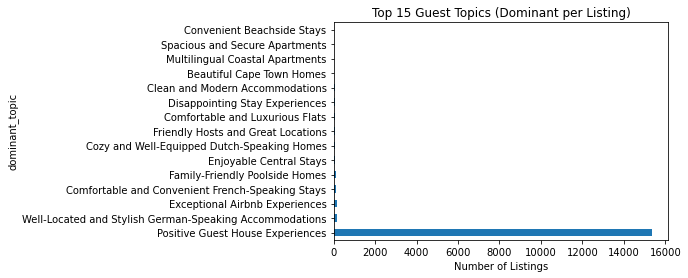

In [ ]:
NLP_final['dominant_topic'].value_counts().nlargest(15).plot(kind='barh')
plt.title("Top 15 Guest Topics (Dominant per Listing)")
plt.xlabel("Number of Listings")


In [ ]:
NLP_filtered = NLP_final[NLP_final['dominant_topic'] != 'Positive Guest House Experiences']


Text(0.5, 0, 'Number of Listings')

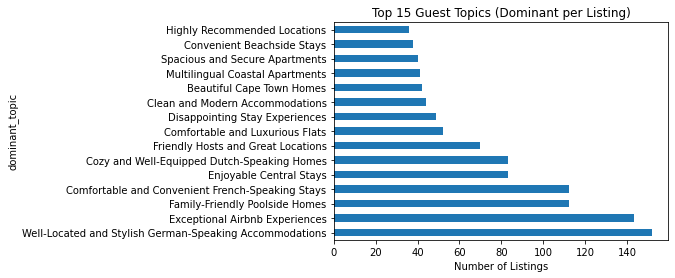

In [ ]:
NLP_filtered['dominant_topic'].value_counts().nlargest(15).plot(kind='barh')
plt.title("Top 15 Guest Topics (Dominant per Listing)")
plt.xlabel("Number of Listings")


In [ ]:
ct = pd.crosstab(NLP_final['dominant_topic'], NLP_final['dominant_sentiment'])
print(ct.columns)


Index(['Negative', 'Neutral', 'Positive'], dtype='object', name='dominant_sentiment')


Text(0, 0.5, 'Number of Listings')

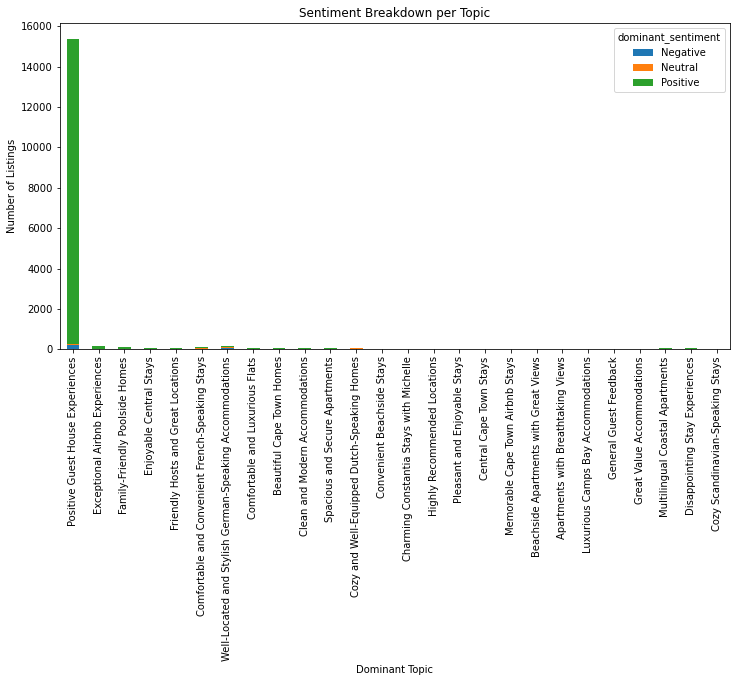

In [ ]:
pd.crosstab(NLP_final['dominant_topic'], NLP_final['dominant_sentiment']) \
  .loc[lambda d: d.sum(1) > 20] \
  .sort_values('Positive', ascending=False) \
  .plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title("Sentiment Breakdown per Topic")
plt.xlabel("Dominant Topic")
plt.ylabel("Number of Listings")


Text(0, 0.5, 'Number of Listings')

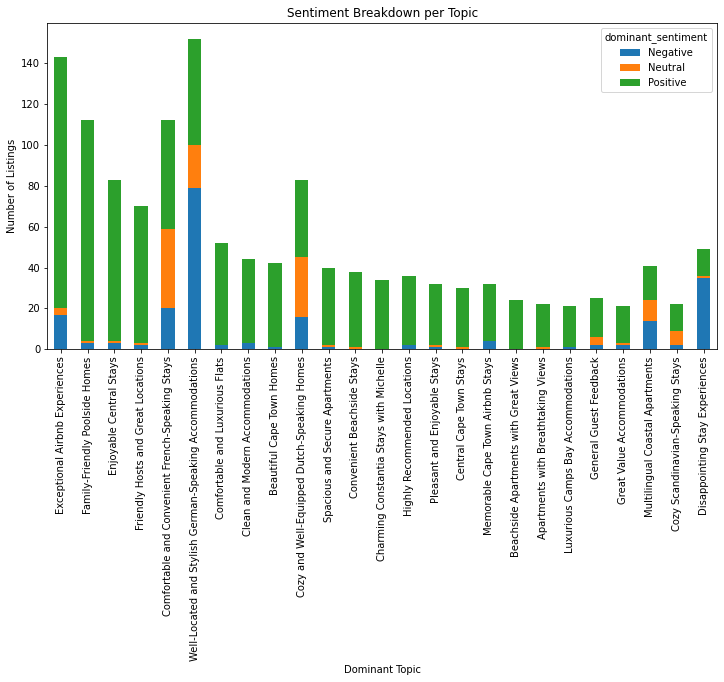

In [ ]:
pd.crosstab(NLP_filtered['dominant_topic'], NLP_filtered['dominant_sentiment']) \
  .loc[lambda d: d.sum(1) > 20] \
  .sort_values('Positive', ascending=False) \
  .plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title("Sentiment Breakdown per Topic")
plt.xlabel("Dominant Topic")
plt.ylabel("Number of Listings")


Text(0.5, 1.0, 'Sentiment by Neighbourhood (Top 10)')

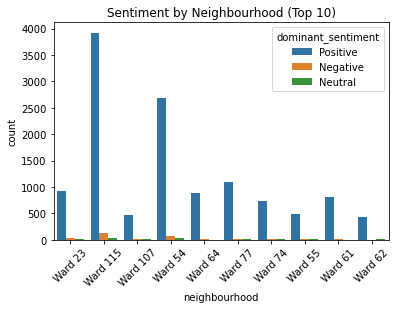

In [ ]:
top_neigh = NLP_final['neighbourhood'].value_counts().nlargest(10).index
sns.countplot(data=NLP_final[NLP_final['neighbourhood'].isin(top_neigh)],
              x='neighbourhood',
              hue='dominant_sentiment')
plt.xticks(rotation=45)
plt.title("Sentiment by Neighbourhood (Top 10)")


Text(0.5, 1.0, 'Sentiment by Neighbourhood (Top 10)')

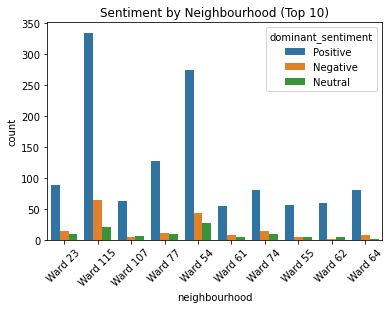

In [ ]:
top_neigh = NLP_filtered['neighbourhood'].value_counts().nlargest(10).index
sns.countplot(data=NLP_filtered[NLP_filtered['neighbourhood'].isin(top_neigh)],
              x='neighbourhood',
              hue='dominant_sentiment')
plt.xticks(rotation=45)
plt.title("Sentiment by Neighbourhood (Top 10)")


Text(0.5, 1.0, 'Sentiment Distribution by Room Type')

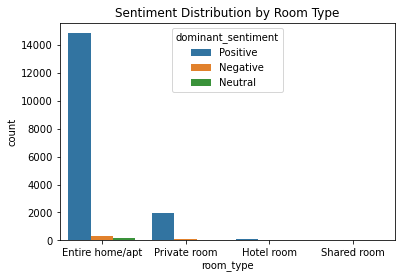

In [ ]:
sns.countplot(data=NLP_final, x='room_type', hue='dominant_sentiment')
plt.title("Sentiment Distribution by Room Type")


Text(0.5, 1.0, 'Sentiment Distribution by Room Type')

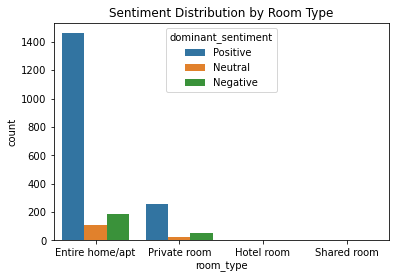

In [ ]:
sns.countplot(data=NLP_filtered, x='room_type', hue='dominant_sentiment')
plt.title("Sentiment Distribution by Room Type")


Text(0.5, 1.0, 'Estimated Revenue per Sentiment Label')

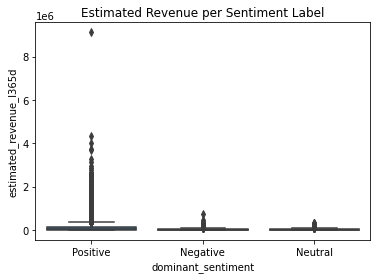

In [ ]:
sns.boxplot(data=NLP_final, x='dominant_sentiment', y='estimated_revenue_l365d')
plt.title("Estimated Revenue per Sentiment Label")


Text(0.5, 1.0, 'Estimated Revenue per Sentiment Label')

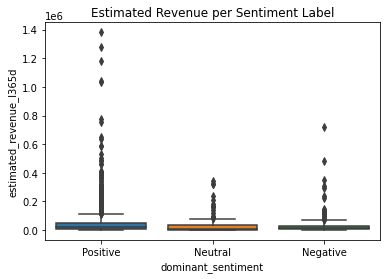

In [ ]:
sns.boxplot(data=NLP_filtered, x='dominant_sentiment', y='estimated_revenue_l365d')
plt.title("Estimated Revenue per Sentiment Label")


Text(0.5, 1.0, 'Occupancy vs Guest Sentiment')

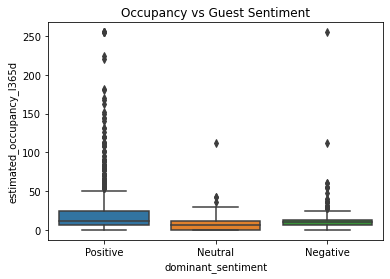

In [ ]:
sns.boxplot(data=NLP_filtered, x='dominant_sentiment', y='estimated_occupancy_l365d')
plt.title("Occupancy vs Guest Sentiment")


In [ ]:
print(NLP_final['dominant_sentiment'].unique())


['Positive' nan 'Negative' 'Neutral']


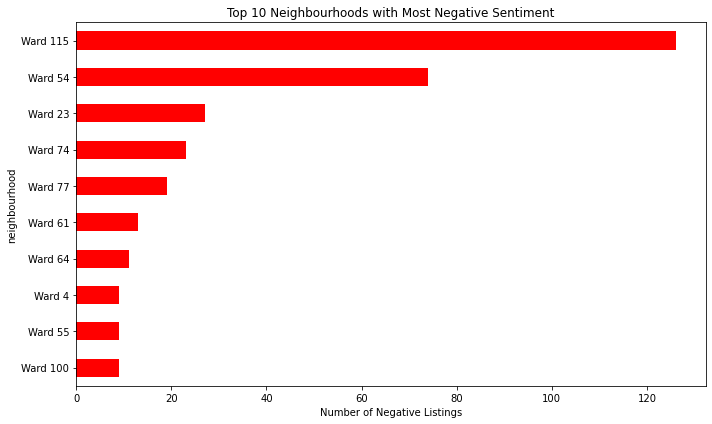

In [ ]:

# Filter for negative sentiment
negative_df = NLP_final[NLP_final['dominant_sentiment'] == 'Negative']

# Count negative reviews per neighbourhood
negative_counts = negative_df['neighbourhood'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
negative_counts.plot(kind='barh', color='red')
plt.xlabel("Number of Negative Listings")
plt.title("Top 10 Neighbourhoods with Most Negative Sentiment")
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.show()


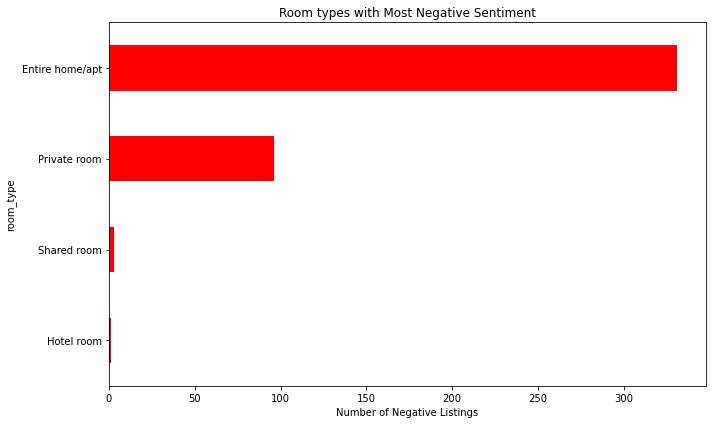

In [ ]:

# Filter for negative sentiment
negative_df = NLP_final[NLP_final['dominant_sentiment'] == 'Negative']

# Count negative reviews per neighbourhood
negative_counts = negative_df['room_type'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
negative_counts.plot(kind='barh', color='red')
plt.xlabel("Number of Negative Listings")
plt.title("Room types with Most Negative Sentiment")
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.show()


In [ ]:
NLP_final.to_csv("data/NLP_final.csv", index=False)
